# Introduction

Our aim is to predict the future population of a country given the previous years population.

We will create a regression model that can predict the future population of 5th and 10th year from the last year.

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import warnings
warnings.simplefilter("ignore") 

Importing our data from World Bank Databank which contains various population indicators 

In [2]:
url='https://databank.worldbank.org/data/download/Population-Estimates_CSV.zip'

In [3]:
import requests
import zipfile
from io import BytesIO

In [4]:
response = requests.get(url)

# Create a BytesIO object from the response content
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extract the CSV files
csv_files = [file for file in zip_file.namelist() if file.endswith('.csv')]

In [5]:
csv_files

['Population-EstimatesCSV.csv',
 'Population-EstimatesCountry.csv',
 'Population-EstimatesSeries.csv',
 'Population-Estimatescountry-series.csv',
 'Population-Estimatesfootnote.csv']

In [6]:
df_list=[]

for file in csv_files:
    with zip_file.open(file) as f:
        df = pd.read_csv(f)
        df_list.append(df)


In [7]:
#Reading the first file
data_total=df_list[0]
data_total

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Africa Eastern and Southern,AFE,Age dependency ratio (% of working-age populat...,SP.POP.DPND,89.594604,89.873370,90.191721,90.574678,90.952719,91.346821,...,6.498351e+01,6.426265e+01,6.356848e+01,6.290357e+01,6.227184e+01,6.167186e+01,6.109308e+01,6.053215e+01,5.998977e+01,5.946634e+01
1,Africa Eastern and Southern,AFE,"Age dependency ratio, old",SP.POP.DPND.OL,5.626944,5.598776,5.571718,5.549702,5.534236,5.526348,...,6.787209e+00,6.872591e+00,6.970254e+00,7.082884e+00,7.210768e+00,7.350748e+00,7.498370e+00,7.650862e+00,7.810104e+00,7.978993e+00
2,Africa Eastern and Southern,AFE,"Age dependency ratio, young",SP.POP.DPND.YG,83.668705,83.936992,84.243994,84.613140,84.994512,85.398509,...,5.762746e+01,5.684522e+01,5.607943e+01,5.533020e+01,5.459988e+01,5.388925e+01,5.319146e+01,5.250547e+01,5.183079e+01,5.116539e+01
3,Africa Eastern and Southern,AFE,"Age population, age 00, female",SP.POP.AG00.FE.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Africa Eastern and Southern,AFE,"Age population, age 00, male",SP.POP.AG00.MA.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50269,Zimbabwe,ZWE,Rural population growth (annual %),SP.RUR.TOTL.ZG,NaN,2.850860,2.805476,2.543135,2.523333,2.508326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50270,Zimbabwe,ZWE,Sex ratio at birth (male births per female bir...,SP.POP.BRTH.MF,1.027000,1.027000,1.026000,1.027000,1.027000,1.027000,...,NaN,NaN,NaN,NaN,1.026000e+00,NaN,NaN,NaN,NaN,1.026000e+00
50271,Zimbabwe,ZWE,Urban population,SP.URB.TOTL,479900.000000,503346.000000,529792.000000,567279.000000,607412.000000,650173.000000,...,9.322234e+06,9.620690e+06,9.923620e+06,1.023146e+07,1.054302e+07,1.085752e+07,1.117563e+07,1.149689e+07,1.182098e+07,1.214774e+07
50272,Zimbabwe,ZWE,Urban population (% of total population),SP.URB.TOTL.IN.ZS,12.608000,12.821000,13.082000,13.578000,14.092000,14.620000,...,4.004400e+01,4.068900e+01,4.133700e+01,4.198900e+01,4.264300e+01,4.329900e+01,4.395800e+01,4.461900e+01,4.528200e+01,4.594700e+01


We can see that the data is organized as a time-series consisting of different indicators

Our target is to estimate future population based on current data.

Our first step is to estimate the future population of a particular country and then to generalize.



In [8]:
data_total['Country Name'].unique()

array(['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle in

In [9]:
#Selecting only the UK data
data_uk_t=data_total[data_total['Country Name']=='United Kingdom']
data_uk_t

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
48006,United Kingdom,GBR,Age dependency ratio (% of working-age populat...,SP.POP.DPND,5.404395e+01,5.419209e+01,5.409745e+01,5.411432e+01,5.453327e+01,5.525793e+01,...,6.509875e+01,6.530014e+01,6.555265e+01,6.594988e+01,6.648048e+01,6.702896e+01,6.752756e+01,6.799603e+01,6.845069e+01,6.891215e+01
48007,United Kingdom,GBR,"Age dependency ratio, old",SP.POP.DPND.OL,1.806058e+01,1.818783e+01,1.826692e+01,1.835924e+01,1.856974e+01,1.889842e+01,...,4.100871e+01,4.116831e+01,4.136257e+01,4.167804e+01,4.210451e+01,4.254589e+01,4.295476e+01,4.334920e+01,4.374497e+01,4.416302e+01
48008,United Kingdom,GBR,"Age dependency ratio, young",SP.POP.DPND.YG,3.598336e+01,3.600426e+01,3.583053e+01,3.575509e+01,3.596353e+01,3.635950e+01,...,2.409004e+01,2.413184e+01,2.419008e+01,2.427184e+01,2.437597e+01,2.448306e+01,2.457280e+01,2.464683e+01,2.470572e+01,2.474914e+01
48009,United Kingdom,GBR,"Age population, age 00, female",SP.POP.AG00.FE.IN,4.289335e+05,4.447895e+05,4.576440e+05,4.680620e+05,4.778265e+05,4.803475e+05,...,3.399660e+05,3.409450e+05,3.415210e+05,3.412400e+05,3.407465e+05,3.395650e+05,3.370960e+05,3.347015e+05,3.318895e+05,3.288495e+05
48010,United Kingdom,GBR,"Age population, age 00, male",SP.POP.AG00.MA.IN,4.526475e+05,4.685935e+05,4.814835e+05,4.911515e+05,5.011930e+05,5.041525e+05,...,3.584225e+05,3.594580e+05,3.600505e+05,3.597430e+05,3.592375e+05,3.579840e+05,3.553880e+05,3.528985e+05,3.499405e+05,3.466890e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48190,United Kingdom,GBR,Rural population growth (annual %),SP.RUR.TOTL.ZG,NaN,1.084669e+00,1.480164e+00,1.380460e+00,1.282931e+00,1.271160e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48191,United Kingdom,GBR,Sex ratio at birth (male births per female bir...,SP.POP.BRTH.MF,1.061000e+00,1.061000e+00,1.061000e+00,1.057000e+00,1.060000e+00,1.059000e+00,...,NaN,NaN,NaN,NaN,1.055000e+00,NaN,NaN,NaN,NaN,1.054000e+00
48192,United Kingdom,GBR,Urban population,SP.URB.TOTL,4.110466e+07,4.138147e+07,4.166120e+07,4.190011e+07,4.209840e+07,4.229420e+07,...,6.300266e+07,6.324278e+07,6.347419e+07,6.369597e+07,6.390900e+07,6.411020e+07,6.429963e+07,6.447800e+07,6.464443e+07,6.479418e+07
48193,United Kingdom,GBR,Urban population (% of total population),SP.URB.TOTL.IN.ZS,7.844400e+01,7.837400e+01,7.823700e+01,7.809900e+01,7.796000e+01,7.782100e+01,...,8.859000e+01,8.878200e+01,8.897100e+01,8.915800e+01,8.934100e+01,8.952200e+01,8.970000e+01,8.987500e+01,9.004800e+01,9.021800e+01


In [10]:
#Pivoting the data to group by year
data_uk=data_uk_t.drop(['Country Name','Country Code','Indicator Code'],axis=1)
data_uk=data_uk.set_index('Indicator Name')
data_uk=data_uk.transpose()
data_uk

Indicator Name,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Age population, age 00, female","Age population, age 00, male","Age population, age 01, female","Age population, age 01, male","Age population, age 02, female","Age population, age 02, male","Age population, age 03, female",...,"Probability of dying among children ages 5-9 years (per 1,000)","Probability of dying among youth ages 20-24 years (per 1,000)","Probability of dying at age 5-14 years (per 1,000 children age 5)",Rural population,Rural population (% of total population),Rural population growth (annual %),Sex ratio at birth (male births per female births),Urban population,Urban population (% of total population),Urban population growth (annual %)
1960,54.043948,18.060583,35.983365,428933.5,452647.5,416422.5,438540.0,408489.5,429735.5,396802.5,...,NaN,NaN,NaN,11295344.0,21.556,NaN,1.061,41104656.0,78.444,NaN
1961,54.192089,18.187827,36.004262,444789.5,468593.5,427540.0,449856.0,415170.5,436655.0,407877.0,...,NaN,NaN,NaN,11418528.0,21.626,1.084669,1.061,41381472.0,78.374,0.671184
1962,54.097445,18.266919,35.830526,457644.0,481483.5,443389.5,465378.5,426311.0,447907.5,414715.0,...,NaN,NaN,NaN,11588798.0,21.763,1.480164,1.061,41661202.0,78.237,0.673704
1963,54.114321,18.359235,35.755085,468062.0,491151.5,456246.0,477888.0,442079.5,463258.0,425865.0,...,NaN,NaN,NaN,11749886.0,21.901,1.380460,1.057,41900114.0,78.099,0.571826
1964,54.533268,18.569736,35.963532,477826.5,501193.0,466663.5,487267.0,454914.0,475596.5,441530.0,...,NaN,NaN,NaN,11901600.0,22.040,1.282931,1.060,42098400.0,77.960,0.472119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,67.028957,42.545892,24.483065,339565.0,357984.0,341760.0,360239.0,343172.5,361664.5,344247.0,...,NaN,NaN,NaN,7503705.0,10.478,NaN,NaN,64110199.0,89.522,NaN
2047,67.527561,42.954761,24.572800,337096.0,355388.0,340581.5,358988.0,342682.0,361162.5,343970.0,...,NaN,NaN,NaN,7383347.0,10.300,NaN,NaN,64299629.0,89.700,NaN
2048,67.996027,43.349201,24.646826,334701.5,352898.5,338116.0,356395.5,341504.5,359912.5,343480.0,...,NaN,NaN,NaN,7263864.0,10.125,NaN,NaN,64478000.0,89.875,NaN
2049,68.450685,43.744965,24.705720,331889.5,349940.5,335724.5,353909.0,339040.0,357321.0,342302.5,...,NaN,NaN,NaN,7144427.0,9.952,NaN,NaN,64644429.0,90.048,NaN


In [11]:
#Converting to date_time object
data_uk.index=pd.to_datetime(data_uk.index)

data_uk.index=data_uk.index.year
data_uk

Indicator Name,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Age population, age 00, female","Age population, age 00, male","Age population, age 01, female","Age population, age 01, male","Age population, age 02, female","Age population, age 02, male","Age population, age 03, female",...,"Probability of dying among children ages 5-9 years (per 1,000)","Probability of dying among youth ages 20-24 years (per 1,000)","Probability of dying at age 5-14 years (per 1,000 children age 5)",Rural population,Rural population (% of total population),Rural population growth (annual %),Sex ratio at birth (male births per female births),Urban population,Urban population (% of total population),Urban population growth (annual %)
1960,54.043948,18.060583,35.983365,428933.5,452647.5,416422.5,438540.0,408489.5,429735.5,396802.5,...,NaN,NaN,NaN,11295344.0,21.556,NaN,1.061,41104656.0,78.444,NaN
1961,54.192089,18.187827,36.004262,444789.5,468593.5,427540.0,449856.0,415170.5,436655.0,407877.0,...,NaN,NaN,NaN,11418528.0,21.626,1.084669,1.061,41381472.0,78.374,0.671184
1962,54.097445,18.266919,35.830526,457644.0,481483.5,443389.5,465378.5,426311.0,447907.5,414715.0,...,NaN,NaN,NaN,11588798.0,21.763,1.480164,1.061,41661202.0,78.237,0.673704
1963,54.114321,18.359235,35.755085,468062.0,491151.5,456246.0,477888.0,442079.5,463258.0,425865.0,...,NaN,NaN,NaN,11749886.0,21.901,1.380460,1.057,41900114.0,78.099,0.571826
1964,54.533268,18.569736,35.963532,477826.5,501193.0,466663.5,487267.0,454914.0,475596.5,441530.0,...,NaN,NaN,NaN,11901600.0,22.040,1.282931,1.060,42098400.0,77.960,0.472119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,67.028957,42.545892,24.483065,339565.0,357984.0,341760.0,360239.0,343172.5,361664.5,344247.0,...,NaN,NaN,NaN,7503705.0,10.478,NaN,NaN,64110199.0,89.522,NaN
2047,67.527561,42.954761,24.572800,337096.0,355388.0,340581.5,358988.0,342682.0,361162.5,343970.0,...,NaN,NaN,NaN,7383347.0,10.300,NaN,NaN,64299629.0,89.700,NaN
2048,67.996027,43.349201,24.646826,334701.5,352898.5,338116.0,356395.5,341504.5,359912.5,343480.0,...,NaN,NaN,NaN,7263864.0,10.125,NaN,NaN,64478000.0,89.875,NaN
2049,68.450685,43.744965,24.705720,331889.5,349940.5,335724.5,353909.0,339040.0,357321.0,342302.5,...,NaN,NaN,NaN,7144427.0,9.952,NaN,NaN,64644429.0,90.048,NaN


In [12]:
#For training & testing , we will use data upto 2020,data beyond is predicted data
data_uk_sel=data_uk.loc['1960':'2020']
data_uk_sel

Indicator Name,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Age population, age 00, female","Age population, age 00, male","Age population, age 01, female","Age population, age 01, male","Age population, age 02, female","Age population, age 02, male","Age population, age 03, female",...,"Probability of dying among children ages 5-9 years (per 1,000)","Probability of dying among youth ages 20-24 years (per 1,000)","Probability of dying at age 5-14 years (per 1,000 children age 5)",Rural population,Rural population (% of total population),Rural population growth (annual %),Sex ratio at birth (male births per female births),Urban population,Urban population (% of total population),Urban population growth (annual %)
1960,54.043948,18.060583,35.983365,428933.5,452647.5,416422.5,438540.0,408489.5,429735.5,396802.5,...,NaN,NaN,NaN,11295344.0,21.556,NaN,1.061,41104656.0,78.444,NaN
1961,54.192089,18.187827,36.004262,444789.5,468593.5,427540.0,449856.0,415170.5,436655.0,407877.0,...,NaN,NaN,NaN,11418528.0,21.626,1.084669,1.061,41381472.0,78.374,0.671184
1962,54.097445,18.266919,35.830526,457644.0,481483.5,443389.5,465378.5,426311.0,447907.5,414715.0,...,NaN,NaN,NaN,11588798.0,21.763,1.480164,1.061,41661202.0,78.237,0.673704
1963,54.114321,18.359235,35.755085,468062.0,491151.5,456246.0,477888.0,442079.5,463258.0,425865.0,...,NaN,NaN,NaN,11749886.0,21.901,1.380460,1.057,41900114.0,78.099,0.571826
1964,54.533268,18.569736,35.963532,477826.5,501193.0,466663.5,487267.0,454914.0,475596.5,441530.0,...,NaN,NaN,NaN,11901600.0,22.040,1.282931,1.060,42098400.0,77.960,0.472119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,55.701031,27.985639,27.715392,380481.0,400923.0,382568.0,402934.5,386431.5,406549.5,397189.5,...,0.4,1.8,NaN,11228768.0,17.114,-0.749926,1.054,54382825.0,82.886,1.072052
2017,56.297703,28.357835,27.939868,374679.5,394719.0,382207.0,402706.0,385544.0,405951.5,389354.0,...,0.4,1.9,NaN,11135542.0,16.857,-0.833708,1.053,54923317.0,83.143,0.988959
2018,56.814751,28.731812,28.082939,363133.0,382700.5,376236.0,396323.0,384998.0,405525.0,388343.5,...,0.3,1.9,NaN,11033746.0,16.602,-0.918358,1.055,55426598.0,83.398,0.912161
2019,57.244549,29.138520,28.106029,351309.5,370494.0,364554.0,384175.0,378857.0,398923.0,387653.5,...,0.3,1.8,NaN,10926403.0,16.348,-0.977624,1.055,55909924.0,83.652,0.868231


In [13]:
list(data_uk_sel.columns)

['Age dependency ratio (% of working-age population)',
 'Age dependency ratio, old',
 'Age dependency ratio, young',
 'Age population, age 00, female',
 'Age population, age 00, male',
 'Age population, age 01, female',
 'Age population, age 01, male',
 'Age population, age 02, female',
 'Age population, age 02, male',
 'Age population, age 03, female',
 'Age population, age 03, male',
 'Age population, age 04, female',
 'Age population, age 04, male',
 'Age population, age 05, female',
 'Age population, age 05, male',
 'Age population, age 06, female',
 'Age population, age 06, male',
 'Age population, age 07, female',
 'Age population, age 07, male',
 'Age population, age 08, female',
 'Age population, age 08, male',
 'Age population, age 09, female',
 'Age population, age 09, male',
 'Age population, age 10, female',
 'Age population, age 10, male',
 'Age population, age 11, female',
 'Age population, age 11, male',
 'Age population, age 12, female',
 'Age population, age 12, male',

Text(0, 0.5, 'Population')

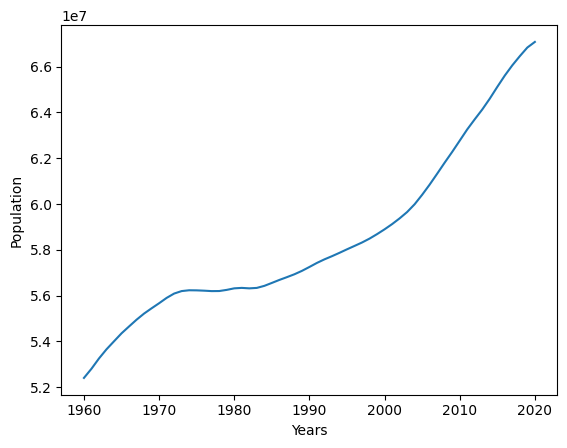

In [14]:
#Checking the population trend
plt.plot(data_uk_sel['Population, total'])
plt.xlabel('Years')
plt.ylabel('Population')

# Baseline Model

First we will predict the population of future 10 based on population of previous 10 years

In [15]:
df_pop=data_uk_sel['Population, total']
df_pop_growth=data_uk_sel['Population growth (annual %)']

Defining future population based on current population growth

In [16]:
#Defining a basemodel to predict the future population based on current growth rate
def basemodel(dataset_pop,dataset_pop_growth,delay):

    predicted = []

    #delay specifies after how many data points from input width will output prediction be made

    for i in np.arange(len(dataset_pop) - delay - 1):  #index upto which input is taken
      predicted.append(dataset_pop.iloc[i]*np.power((1+dataset_pop_growth.iloc[i]/100),delay))


    return(pd.DataFrame(predicted,index=dataset_pop.index[-((len(dataset_pop) - delay - 1)):],columns=['Predicted']))


In [17]:
#Predicting data for 5th &  10th year
df_pop_predicted_base_5=basemodel(df_pop,df_pop_growth,delay=5)
df_pop_predicted_base_10=basemodel(df_pop,df_pop_growth,delay=10)


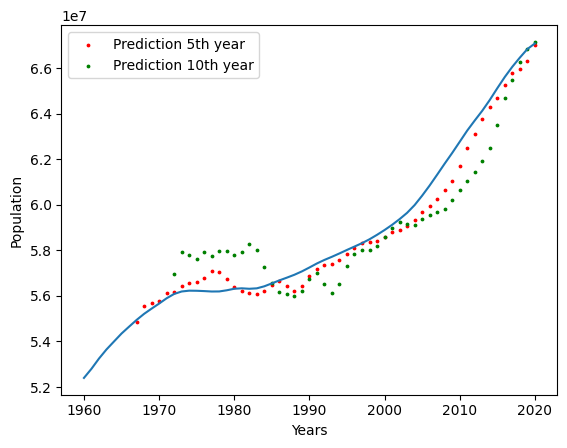

In [18]:
#Checking the population estimate based on basemodel
plt.plot(data_uk_sel['Population, total'])
plt.scatter(df_pop_predicted_base_5.index,df_pop_predicted_base_5,s=3,c='red',label='Prediction 5th year')
plt.scatter(df_pop_predicted_base_10.index,df_pop_predicted_base_10,s=3,c='green',label='Prediction 10th year')
plt.xlabel('Years')
plt.ylabel('Population')
plt.legend()

In [19]:
from sklearn import metrics
mape_base_5=metrics.mean_absolute_percentage_error(df_pop.loc['2009':],df_pop_predicted_base_5.loc['2009':])
mape_base_10=metrics.mean_absolute_percentage_error(df_pop.loc['2014':],df_pop_predicted_base_10.loc['2014':])
df_metrics=pd.DataFrame({'Basemodel':[mape_base_5,mape_base_10]},index=['Prediction 5th','Prediction 10th'])
df_metrics

,Basemodel
Prediction 5th,0.008479
Prediction 10th,0.012140


# Using ARIMA to forecast future 5 & 10 year population

For using ARIMA, we have to make the series stationary

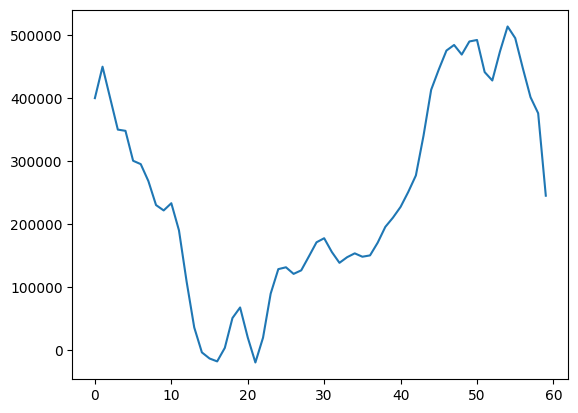

In [20]:
df_diff_1=np.diff(df_pop)
plt.plot(df_diff_1)

In [21]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [22]:
#Running the ADF test to check if our series is stationary
ADF_result = adfuller(df_diff_1)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.0583457897573822
p-value: 0.2615902868040547


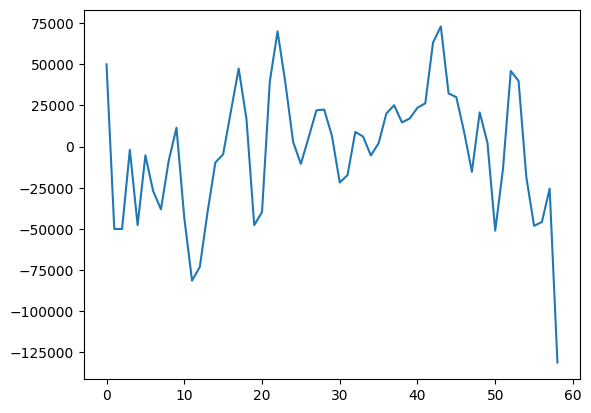

In [23]:
df_diff_2=np.diff(df_diff_1)
plt.plot(df_diff_2)

Since p-value is smaller than 0.05, our series is stationary

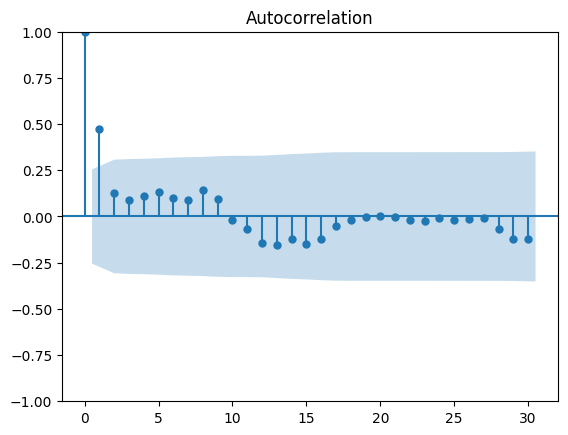

In [24]:
plot_acf(df_diff_2, lags=30);

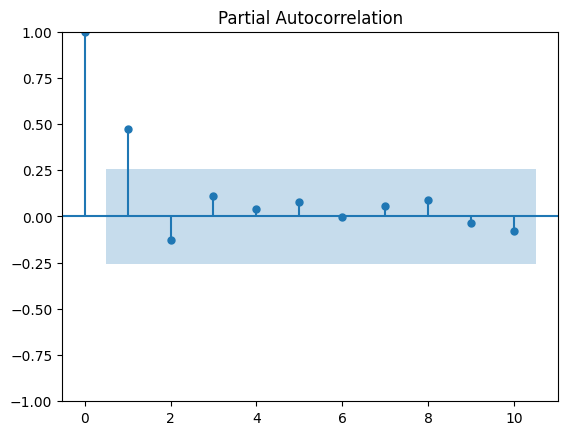

In [25]:
plot_pacf(df_diff_2, lags=10);

From the above ACF and PACF plots, we can see that the population is a Moving Average and Auto-Regressive process combination

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
train_size=len(df_pop.loc['1960':'1995'])
total_size=len(df_pop)

Using AIC score to check the order

In [28]:
from itertools import product

In [29]:
p_list=np.arange(0,4) #Order of AR
q_list=np.arange(0,4) #Order of MA
order_list=list(product(p_list, q_list))

In [30]:
aic_list=[]
order_seq=[]

for order in order_list:
    model=SARIMAX(endog=df_pop,order=(order[0],2,order[1]),simple_differencing=False)
    res=model.fit(disp=False)
    aic=res.aic
    aic_list.append(aic)
    order_seq.append(order)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

In [31]:
df_aic=pd.DataFrame({'(p,q)':order_seq,'AIC':aic_list})
df_aic.sort_values(by='AIC')

,"(p,q)",AIC
0,"(0, 0)",1416.066134
9,"(2, 1)",1418.961053
4,"(1, 0)",1419.854570
6,"(1, 2)",1423.321496
8,"(2, 0)",1424.027595
1,"(0, 1)",1424.298156
12,"(3, 0)",1426.409835
13,"(3, 1)",1427.706982
5,"(1, 1)",1427.738417
11,"(2, 3)",1428.412028


Order chosen  for ARIMA=(2,2,1) ,  as (p,d,q) where p=order of Moving Average
                                                    d=order of difference
                                                    q=order of autoregression
                                                    
                                       

We will use a rolling window to forecast next step and use the forecast to predict next value

Specifically, we will use data from 1960 to 1995 to predict 2000 & 2005 data and so on upto 2020

In [32]:
#Defining a model to predict using ARIMA
def predict_arima(dataset,train_len,total_len,delay,order):


  pred_list=[]
  for i in range(train_len,total_len-delay+1):
    train_data=dataset.iloc[:i]                    #Choosing the dataset upto training length and increasing the training data to make next predictions

    for d in range(delay):                         #Using the rolling window method

      model=SARIMAX(endog=train_data,order=order)
      model_fit=model.fit(disp=False)
      predictions=model_fit.forecast(steps=1)      #Forecasting one step at a time
      next_prediction=predictions.iloc[-1]
      train_data.loc[len(train_data)]=next_prediction     #Appending the forecasted data to the training set

    pred_list.append(next_prediction)

  return pd.DataFrame(pred_list,index=dataset.index[train_len+delay-1:total_len])



In [33]:
df_pop_predicted_arima_5=predict_arima(df_pop,train_size,total_size,delay=5,order=(2,2,1))

df_pop_predicted_arima_10=predict_arima(df_pop,train_size,total_size,delay=10,order=(2,2,1))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. for

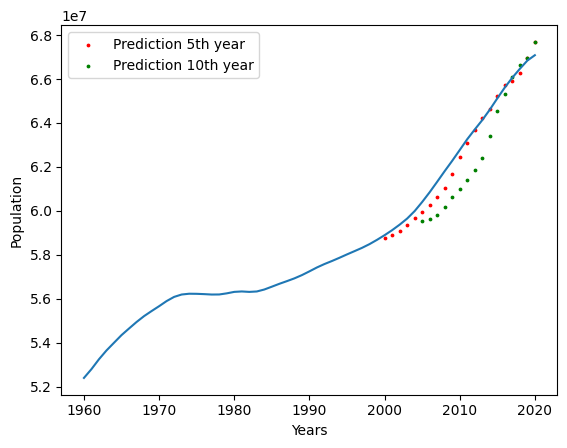

In [34]:
#Checking the population estimate based on arima model
plt.plot(data_uk_sel['Population, total'])
plt.scatter(df_pop_predicted_arima_5.index,df_pop_predicted_arima_5,s=3,c='red',label='Prediction 5th year')
plt.scatter(df_pop_predicted_arima_10.index,df_pop_predicted_arima_10,s=3,c='green',label='Prediction 10th year')
plt.xlabel('Years')
plt.ylabel('Population')
plt.legend()

In [35]:
mape_arima_5=metrics.mean_absolute_percentage_error(df_pop.loc['2009':],df_pop_predicted_arima_5.loc['2009':])
mape_arima_10=metrics.mean_absolute_percentage_error(df_pop.loc['2014':],df_pop_predicted_arima_10.loc['2014':])
df_metrics['Arima model']=[mape_arima_5,mape_arima_10]
df_metrics

,Basemodel,Arima model
Prediction 5th,0.008479,0.003206
Prediction 10th,0.012140,0.006591


ARIMA model has significantly better prediction capacity than basemodel

Until now, we have considered only the population trend to forecast future population without considering the effect of external variables.

Next stage, we will implement LSTM model, which will take into account external factors

# Pre-processing & Predicting using  LSTM Model

In [36]:
data_uk_c=data_uk_sel

In [37]:
data_uk_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 1960 to 2020
Columns: 189 entries, Age dependency ratio (% of working-age population) to Urban population growth (annual %)
dtypes: float64(189)
memory usage: 90.3 KB


Since there are 189 columns, we need to reduce the no. of variables

Checking for occurence of null columns

In [38]:
df_temp=data_uk_c.isnull().sum().sort_values(ascending=False)>5
null_columns=df_temp[df_temp==True].index
null_columns

Index(['Probability of dying at age 5-14 years (per 1,000 children age 5)',
       'Number of deaths ages 5-14 years',
       'Probability of dying among children ages 5-9 years (per 1,000)',
       'Probability of dying among adolescents ages 15-19 years (per 1,000)',
       'Probability of dying among adolescents ages 10-19 years (per 1,000)',
       'Probability of dying among youth ages 20-24 years (per 1,000)',
       'Probability of dying among adolescents ages 10-14 years (per 1,000)',
       'Number of deaths ages 10-14 years',
       'Number of deaths ages 10-19 years',
       'Number of deaths ages 15-19 years',
       'Number of deaths ages 20-24 years', 'Number of deaths ages 5-9 years'],
      dtype='object', name='Indicator Name')

In [39]:
#Dropping the null columns
data_uk_c=data_uk_c.drop(list(null_columns),axis=1)

In [40]:
len(data_uk_c.columns)

177

We can see that there are a lot of features still present.

Many columns are separately given for male and female, we will remove those


In [41]:
#Selecting and dropping gender columns

gender_columns = data_uk_c.filter(like='male')
gender_columns

Indicator Name,"Age population, age 00, female","Age population, age 00, male","Age population, age 01, female","Age population, age 01, male","Age population, age 02, female","Age population, age 02, male","Age population, age 03, female","Age population, age 03, male","Age population, age 04, female","Age population, age 04, male",...,"Population ages 75-79, male (% of male population)","Population ages 80 and above, female","Population ages 80 and above, male","Population ages 80 and above, male (% of male population)","Population ages 80 and older, female (% of female population)","Population, female","Population, female (% of total population)","Population, male","Population, male (% of total population)",Sex ratio at birth (male births per female births)
1960,428933.5,452647.5,416422.5,438540.0,408489.5,429735.5,396802.5,417128.0,382416.0,401985.5,...,1.741819,678125.0,336290.0,1.328709,2.503186,27090467.0,51.699365,25309533.0,48.300635,1.061
1961,444789.5,468593.5,427540.0,449856.0,415170.5,436655.0,407877.0,428586.0,397265.5,417297.5,...,1.726063,700593.0,341952.0,1.339957,2.568120,27280397.0,51.667419,25519603.0,48.332581,1.061
1962,457644.0,481483.5,443389.5,465378.5,426311.0,447907.5,414715.0,435589.0,408284.5,428590.5,...,1.711510,721018.0,345275.0,1.340715,2.622177,27496932.0,51.637431,25753068.0,48.362569,1.061
1963,468062.0,491151.5,456246.0,477888.0,442079.5,463258.0,425865.0,446825.0,415081.0,435501.5,...,1.704696,737505.0,344879.0,1.328465,2.663502,27689292.0,51.610983,25960708.0,48.389017,1.057
1964,477826.5,501193.0,466663.5,487267.0,454914.0,475596.5,441530.0,462059.0,426033.5,446556.0,...,1.704256,756688.0,345952.0,1.323294,2.716354,27856762.0,51.586597,26143238.0,48.413403,1.060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,380481.0,400923.0,382568.0,402934.5,386431.5,406549.5,397189.5,417490.0,405279.5,425382.5,...,3.079790,1923402.0,1243002.0,3.843434,5.781073,33270675.0,50.708531,32340918.0,49.291469,1.054
2017,374679.5,394719.0,382207.0,402706.0,385544.0,405951.5,389354.0,409757.0,399930.0,420517.0,...,3.092902,1947392.0,1281205.0,3.932308,5.817042,33477363.0,50.678083,32581496.0,49.321917,1.053
2018,363133.0,382700.5,376236.0,396323.0,384998.0,405525.0,388343.5,409016.0,392038.5,412768.5,...,3.154171,1972353.0,1320147.0,4.025050,5.859274,33662065.0,50.649851,32798279.0,49.350149,1.055
2019,351309.5,370494.0,364554.0,384175.0,378857.0,398923.0,387653.5,408433.5,390835.0,411802.0,...,3.257041,2004041.0,1362177.0,4.127743,5.922842,33835792.0,50.624853,33000535.0,49.375147,1.055


In [42]:
data_uk_c=data_uk_c.drop(list(gender_columns),axis=1)


In [43]:
data_uk_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 1960 to 2020
Data columns (total 28 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Age dependency ratio (% of working-age population)    61 non-null     float64
 1   Age dependency ratio, old                             61 non-null     float64
 2   Age dependency ratio, young                           61 non-null     float64
 3   Birth rate, crude (per 1,000 people)                  61 non-null     float64
 4   Death rate, crude (per 1,000 people)                  61 non-null     float64
 5   Fertility rate, total (births per woman)              61 non-null     float64
 6   Life expectancy at birth, total (years)               61 non-null     float64
 7   Mortality rate, infant (per 1,000 live births)        61 non-null     float64
 8   Mortality rate, neonatal (per 1,000 live births)      61 non-n

In [44]:
#Dropping the null rows
data_uk_c=data_uk_c.dropna(how='any',axis=0)
data_uk_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 1961 to 2020
Data columns (total 28 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Age dependency ratio (% of working-age population)    60 non-null     float64
 1   Age dependency ratio, old                             60 non-null     float64
 2   Age dependency ratio, young                           60 non-null     float64
 3   Birth rate, crude (per 1,000 people)                  60 non-null     float64
 4   Death rate, crude (per 1,000 people)                  60 non-null     float64
 5   Fertility rate, total (births per woman)              60 non-null     float64
 6   Life expectancy at birth, total (years)               60 non-null     float64
 7   Mortality rate, infant (per 1,000 live births)        60 non-null     float64
 8   Mortality rate, neonatal (per 1,000 live births)      60 non-n

In [45]:
#Splitting our data into train & test set
df_uk_train=data_uk_c.loc[:2005]   #Labels will be taken upto 1996-2000 and target upto 2005
df_uk_test=data_uk_c.loc[2001:]  #Labels will be taken from 2001-2005 and target from 2009


In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df_uk_train_scaled=scaler.fit_transform(df_uk_train)
df_uk_test_scaled=scaler.transform(df_uk_test)

Defining an inverse transform function to retrive original data

In [47]:
def inverse_transform(data,scaler,target):
  dict_features={j:i for i,j in enumerate(scaler.get_feature_names_out())}

  dict_index=dict_features[target]

  min_value=scaler.data_min_[dict_index]
  max_value=scaler.data_max_[dict_index]
  transformed_data=data*(max_value-min_value)+min_value

  return transformed_data


In [48]:
#Converting into dataframes
df_uk_train_scaled=pd.DataFrame(df_uk_train_scaled,columns=scaler.get_feature_names_out())
df_uk_test_scaled=pd.DataFrame(df_uk_test_scaled,columns=scaler.get_feature_names_out())

In [49]:
def create_dataset(dataset,input_width,delay=0,target=None):
    data_X, data_Y = [], []
    window_size= input_width+delay    #delay specifies after how many data pints from input width will output prediction be made


    for i in range(len(dataset) - window_size+1):  #index upto which input is taken
        data_X.append(dataset.loc[i:(i + input_width-1), :])


        data_Y.append(dataset.loc[(i + input_width+delay-1), target])


    return(np.array(data_X),np.array(data_Y))

In [50]:
#Creating training dataset for 5th year prediction
train_X_5,train_Y_5 = create_dataset(df_uk_train_scaled,input_width=5,delay=5,target='Population, total')
test_X_5,test_Y_5 = create_dataset(df_uk_test_scaled, input_width=5,delay=5,target='Population, total')

In [51]:
#Creating training dataset for 10th year prediction
train_X_10,train_Y_10 = create_dataset(df_uk_train_scaled,input_width=5,delay=10,target='Population, total')
test_X_10,test_Y_10 = create_dataset(df_uk_test_scaled, input_width=5,delay=10,target='Population, total')

In [52]:
#Checking length of X train
print(f'Shape of X train 5:{train_X_5.shape}')
print(f'Shape of X train 10:{train_X_10.shape}')

#Checking length of  Y train
print(f'Shape of Y train 5:{train_Y_5.shape}')
print(f'Shape of Y train 10:{train_Y_10.shape}')


Shape of X train 5:(36, 5, 28)
Shape of X train 10:(31, 5, 28)
Shape of Y train 5:(36,)
Shape of Y train 10:(31,)


In [53]:
#Defining a function to shuffle the train datasets to produce more robust result
def shuffle_dataset(input,target):
  indices=np.arange(input.shape[0])
  np.random.shuffle(indices)
  shuffled_input = input[indices]
  shuffled_target = target[indices]
  return shuffled_input,shuffled_target

In [54]:
#Shuffling only the train dataset
train_X_5,train_Y_5  = shuffle_dataset(train_X_5,train_Y_5 )
train_X_10,train_Y_10 = shuffle_dataset(train_X_10,train_Y_10)

In [55]:
from tensorflow import keras

from keras.models import Model
from keras.layers import Input,Dense,Activation,BatchNormalization,LSTM,Bidirectional

In [56]:
def lstm_model(train_X,train_Y,test_X,test_Y,shape=(5,28),epoch=300,batch_size=16):
  input=Input(shape=shape)

  x=LSTM(1024,return_sequences=True)(input)

  x=LSTM(1024)(x)

  output=Dense(1)(x)

  model = Model(input, output)

  model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001), loss="mse", metrics=["mae"])

  callback=keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

  history=model.fit(x=train_X,y=train_Y,epochs=epoch,validation_data=[test_X,test_Y],batch_size=16,callbacks=[callback])

  predicted_values=model.predict(test_X)[:,0]

  return predicted_values

In [57]:
#Predictig value for 5th year
predicted_values_5=lstm_model(train_X_5,train_Y_5,test_X_5,test_Y_5,shape=(5,28),epoch=500,batch_size=16)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.5928 - mae: 0.7354 - val_loss: 1.1825 - val_mae: 1.0784
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0680 - mae: 0.2432 - val_loss: 0.4132 - val_mae: 0.6340
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0047 - mae: 0.0534 - val_loss: 0.3240 - val_mae: 0.5609
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0039 - mae: 0.0526 - val_loss: 0.3097 - val_mae: 0.5489
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0028 - mae: 0.0366 - val_loss: 0.2009 - val_mae: 0.4416
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0017 - mae: 0.0304 - val_loss: 0.1618 - val_mae: 0.3966
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0017 - mae: 0.0288 - val_loss: 0.1118 - val_mae: 0.3298
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0831 - val_mae: 0.2844
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 9.4436e-04 - 

In [58]:
#Predicting value for 10th year
predicted_values_10=lstm_model(train_X_10,train_Y_10,test_X_10,test_Y_10,shape=(5,28),epoch=500,batch_size=16)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - loss: 0.5598 - mae: 0.6804 - val_loss: 2.6822 - val_mae: 1.6352
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2437 - mae: 0.4617 - val_loss: 1.4624 - val_mae: 1.2068
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0433 - mae: 0.1744 - val_loss: 0.7780 - val_mae: 0.8799
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0044 - mae: 0.0443 - val_loss: 0.4991 - val_mae: 0.7047
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0018 - mae: 0.0365 - val_loss: 0.4197 - val_mae: 0.6463
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0023 - mae: 0.0408 - val_loss: 0.4376 - val_mae: 0.6602
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0013 - mae: 0.0277 - val_loss: 0.4767 - val_mae: 0.6892
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 0.4151 - val_mae: 0.6432
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0014 - mae:

In [59]:
#Inverse scaling the population
predicted_population_5=inverse_transform(predicted_values_5,scaler,'Population, total')
predicted_population_10=inverse_transform(predicted_values_10,scaler,'Population, total')

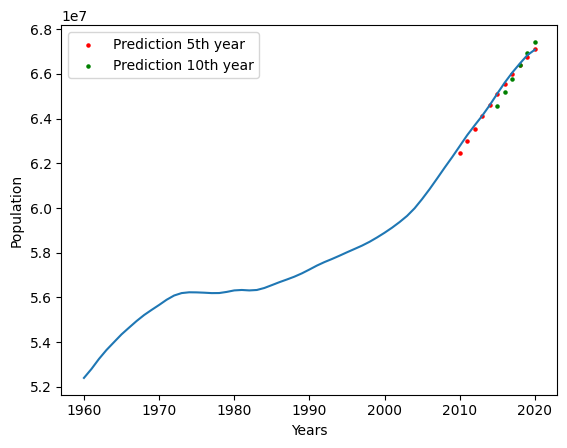

In [60]:
#Checking the population estimate based on lstm
plt.plot(data_uk_sel['Population, total'])
plt.scatter(data_uk_sel['Population, total'].index[-len(predicted_population_5):],predicted_population_5,s=5,c='red',label='Prediction 5th year')
plt.scatter(data_uk_sel['Population, total'].index[-len(predicted_population_10):],predicted_population_10,s=5,c='green',label='Prediction 10th year')
plt.xlabel('Years')
plt.ylabel('Population')
plt.legend()

In [61]:
#Evaluating metrics
mape_lstm_5=metrics.mean_absolute_percentage_error(df_pop.iloc[-len(predicted_population_5):],predicted_population_5)
mape_lstm_10=metrics.mean_absolute_percentage_error(df_pop.iloc[-len(predicted_population_10):],predicted_population_10)
df_metrics['LSTM Model']=[mape_lstm_5,mape_lstm_10]
df_metrics

,Basemodel,Arima model,LSTM Model
Prediction 5th,0.008479,0.003206,0.001595
Prediction 10th,0.012140,0.006591,0.004503


From above , we can clearly see that LSTM model performs the best for both 5 years and 10 years.


We will now make a general model to estimate population for any country based on certain demographic factors

# Pre-processing & Predicting  for General model

In [62]:
data_total

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Africa Eastern and Southern,AFE,Age dependency ratio (% of working-age populat...,SP.POP.DPND,89.594604,89.873370,90.191721,90.574678,90.952719,91.346821,...,6.498351e+01,6.426265e+01,6.356848e+01,6.290357e+01,6.227184e+01,6.167186e+01,6.109308e+01,6.053215e+01,5.998977e+01,5.946634e+01
1,Africa Eastern and Southern,AFE,"Age dependency ratio, old",SP.POP.DPND.OL,5.626944,5.598776,5.571718,5.549702,5.534236,5.526348,...,6.787209e+00,6.872591e+00,6.970254e+00,7.082884e+00,7.210768e+00,7.350748e+00,7.498370e+00,7.650862e+00,7.810104e+00,7.978993e+00
2,Africa Eastern and Southern,AFE,"Age dependency ratio, young",SP.POP.DPND.YG,83.668705,83.936992,84.243994,84.613140,84.994512,85.398509,...,5.762746e+01,5.684522e+01,5.607943e+01,5.533020e+01,5.459988e+01,5.388925e+01,5.319146e+01,5.250547e+01,5.183079e+01,5.116539e+01
3,Africa Eastern and Southern,AFE,"Age population, age 00, female",SP.POP.AG00.FE.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Africa Eastern and Southern,AFE,"Age population, age 00, male",SP.POP.AG00.MA.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50269,Zimbabwe,ZWE,Rural population growth (annual %),SP.RUR.TOTL.ZG,NaN,2.850860,2.805476,2.543135,2.523333,2.508326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50270,Zimbabwe,ZWE,Sex ratio at birth (male births per female bir...,SP.POP.BRTH.MF,1.027000,1.027000,1.026000,1.027000,1.027000,1.027000,...,NaN,NaN,NaN,NaN,1.026000e+00,NaN,NaN,NaN,NaN,1.026000e+00
50271,Zimbabwe,ZWE,Urban population,SP.URB.TOTL,479900.000000,503346.000000,529792.000000,567279.000000,607412.000000,650173.000000,...,9.322234e+06,9.620690e+06,9.923620e+06,1.023146e+07,1.054302e+07,1.085752e+07,1.117563e+07,1.149689e+07,1.182098e+07,1.214774e+07
50272,Zimbabwe,ZWE,Urban population (% of total population),SP.URB.TOTL.IN.ZS,12.608000,12.821000,13.082000,13.578000,14.092000,14.620000,...,4.004400e+01,4.068900e+01,4.133700e+01,4.198900e+01,4.264300e+01,4.329900e+01,4.395800e+01,4.461900e+01,4.528200e+01,4.594700e+01


Our idea is to prepare multiple datasets for any country for which there is a continuos yearly availability of data

In [63]:
data_total['Country Name'].unique()

array(['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle in

In [64]:
non_countries=['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle East & North Africa (IDA & IBRD countries)',
       'Middle income', 'North America', 'Not classified', 'OECD members',
       'Other small states', 'Pacific island small states',
       'Post-demographic dividend', 'Pre-demographic dividend',
       'Small states', 'South Asia', 'South Asia (IDA & IBRD)',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income',
       'World']

In [65]:
#Filtering out only the countries
data_countries=data_total[data_total['Country Name'].isin(non_countries)==False]
data_countries

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
9261,Afghanistan,AFG,Age dependency ratio (% of working-age populat...,SP.POP.DPND,80.051114,80.222340,80.401943,80.715318,81.219557,81.994815,...,6.216425e+01,6.118285e+01,6.025787e+01,5.938392e+01,5.855326e+01,5.776734e+01,5.701620e+01,5.629716e+01,5.562310e+01,5.499672e+01
9262,Afghanistan,AFG,"Age dependency ratio, old",SP.POP.DPND.OL,5.100901,5.078088,5.049558,5.022020,4.999719,4.985287,...,5.506359e+00,5.606058e+00,5.706929e+00,5.808419e+00,5.910002e+00,6.011042e+00,6.111728e+00,6.214201e+00,6.322273e+00,6.442241e+00
9263,Afghanistan,AFG,"Age dependency ratio, young",SP.POP.DPND.YG,74.950213,75.144252,75.352384,75.693297,76.219838,77.009528,...,5.665789e+01,5.557679e+01,5.455094e+01,5.357551e+01,5.264326e+01,5.175630e+01,5.090447e+01,5.008296e+01,4.930082e+01,4.855447e+01
9264,Afghanistan,AFG,"Age population, age 00, female",SP.POP.AG00.FE.IN,178344.500000,182752.000000,187399.500000,192326.500000,197478.000000,202707.000000,...,7.620640e+05,7.661775e+05,7.698215e+05,7.736400e+05,7.776435e+05,7.807635e+05,7.829555e+05,7.838900e+05,7.850285e+05,7.862525e+05
9265,Afghanistan,AFG,"Age population, age 00, male",SP.POP.AG00.MA.IN,182281.000000,186893.500000,191763.000000,196892.000000,202281.000000,207791.500000,...,7.925180e+05,7.967695e+05,8.004515e+05,8.043515e+05,8.085105e+05,8.117455e+05,8.140705e+05,8.149915e+05,8.161645e+05,8.173955e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50269,Zimbabwe,ZWE,Rural population growth (annual %),SP.RUR.TOTL.ZG,NaN,2.850860,2.805476,2.543135,2.523333,2.508326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50270,Zimbabwe,ZWE,Sex ratio at birth (male births per female bir...,SP.POP.BRTH.MF,1.027000,1.027000,1.026000,1.027000,1.027000,1.027000,...,NaN,NaN,NaN,NaN,1.026000e+00,NaN,NaN,NaN,NaN,1.026000e+00
50271,Zimbabwe,ZWE,Urban population,SP.URB.TOTL,479900.000000,503346.000000,529792.000000,567279.000000,607412.000000,650173.000000,...,9.322234e+06,9.620690e+06,9.923620e+06,1.023146e+07,1.054302e+07,1.085752e+07,1.117563e+07,1.149689e+07,1.182098e+07,1.214774e+07
50272,Zimbabwe,ZWE,Urban population (% of total population),SP.URB.TOTL.IN.ZS,12.608000,12.821000,13.082000,13.578000,14.092000,14.620000,...,4.004400e+01,4.068900e+01,4.133700e+01,4.198900e+01,4.264300e+01,4.329900e+01,4.395800e+01,4.461900e+01,4.528200e+01,4.594700e+01


In [66]:
#Filtering out the frequent null_columns and gender columns
data_countries=data_countries[data_countries['Indicator Name'].isin(null_columns)==False]
data_countries=data_countries[data_countries['Indicator Name'].isin(gender_columns)==False]
data_countries

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
9261,Afghanistan,AFG,Age dependency ratio (% of working-age populat...,SP.POP.DPND,80.051114,80.222340,80.401943,80.715318,81.219557,81.994815,...,6.216425e+01,6.118285e+01,6.025787e+01,5.938392e+01,5.855326e+01,5.776734e+01,5.701620e+01,5.629716e+01,5.562310e+01,5.499672e+01
9262,Afghanistan,AFG,"Age dependency ratio, old",SP.POP.DPND.OL,5.100901,5.078088,5.049558,5.022020,4.999719,4.985287,...,5.506359e+00,5.606058e+00,5.706929e+00,5.808419e+00,5.910002e+00,6.011042e+00,6.111728e+00,6.214201e+00,6.322273e+00,6.442241e+00
9263,Afghanistan,AFG,"Age dependency ratio, young",SP.POP.DPND.YG,74.950213,75.144252,75.352384,75.693297,76.219838,77.009528,...,5.665789e+01,5.557679e+01,5.455094e+01,5.357551e+01,5.264326e+01,5.175630e+01,5.090447e+01,5.008296e+01,4.930082e+01,4.855447e+01
9316,Afghanistan,AFG,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,50.340000,50.443000,50.570000,50.703000,50.831000,50.872000,...,NaN,NaN,NaN,NaN,2.378300e+01,NaN,NaN,NaN,NaN,2.207000e+01
9317,Afghanistan,AFG,"Death rate, crude (per 1,000 people)",SP.DYN.CDRT.IN,31.921000,31.349000,30.845000,30.359000,29.867000,29.389000,...,NaN,NaN,NaN,NaN,5.359000e+00,NaN,NaN,NaN,NaN,5.493000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50268,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,87.392000,87.179000,86.918000,86.422000,85.908000,85.380000,...,5.995600e+01,5.931100e+01,5.866300e+01,5.801100e+01,5.735700e+01,5.670100e+01,5.604200e+01,5.538100e+01,5.471800e+01,5.405300e+01
50269,Zimbabwe,ZWE,Rural population growth (annual %),SP.RUR.TOTL.ZG,NaN,2.850860,2.805476,2.543135,2.523333,2.508326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50271,Zimbabwe,ZWE,Urban population,SP.URB.TOTL,479900.000000,503346.000000,529792.000000,567279.000000,607412.000000,650173.000000,...,9.322234e+06,9.620690e+06,9.923620e+06,1.023146e+07,1.054302e+07,1.085752e+07,1.117563e+07,1.149689e+07,1.182098e+07,1.214774e+07
50272,Zimbabwe,ZWE,Urban population (% of total population),SP.URB.TOTL.IN.ZS,12.608000,12.821000,13.082000,13.578000,14.092000,14.620000,...,4.004400e+01,4.068900e+01,4.133700e+01,4.198900e+01,4.264300e+01,4.329900e+01,4.395800e+01,4.461900e+01,4.528200e+01,4.594700e+01


In [67]:
country_list=data_countries['Country Name'].unique()
country_list

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Faroe Islands',

In [68]:
data_countries.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031',
       '2032', '2033', '2034', '2035', '2036', '2037', '2038', '2039', '2040',
       '2041', '2042', '2043', '2044', '2045', '2046', '2047', '2048', '2049',
       '2050'],
      dtype='object')

In [69]:
#Taking data upto 2019
selected_columns=['Country Name', 'Indicator Name',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019']
data_countries_sel=data_countries[selected_columns]
data_countries_sel

,Country Name,Indicator Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
9261,Afghanistan,Age dependency ratio (% of working-age populat...,80.051114,80.222340,80.401943,80.715318,81.219557,81.994815,82.954722,83.908073,...,1.054334e+02,1.025860e+02,9.930036e+01,9.712553e+01,9.470670e+01,9.304245e+01,9.201212e+01,9.054309e+01,8.909145e+01,8.764932e+01
9262,Afghanistan,"Age dependency ratio, old",5.100901,5.078088,5.049558,5.022020,4.999719,4.985287,4.979162,4.976931,...,4.834730e+00,4.809149e+00,4.767237e+00,4.737487e+00,4.690797e+00,4.644246e+00,4.606351e+00,4.572687e+00,4.551607e+00,4.536901e+00
9263,Afghanistan,"Age dependency ratio, young",74.950213,75.144252,75.352384,75.693297,76.219838,77.009528,77.975560,78.931143,...,1.005987e+02,9.777682e+01,9.453312e+01,9.238805e+01,9.001590e+01,8.839820e+01,8.740577e+01,8.597041e+01,8.453984e+01,8.311242e+01
9316,Afghanistan,"Birth rate, crude (per 1,000 people)",50.340000,50.443000,50.570000,50.703000,50.831000,50.872000,50.986000,51.081000,...,4.060200e+01,3.985500e+01,4.000900e+01,3.960100e+01,3.910500e+01,3.880300e+01,3.793600e+01,3.734200e+01,3.692700e+01,3.646600e+01
9317,Afghanistan,"Death rate, crude (per 1,000 people)",31.921000,31.349000,30.845000,30.359000,29.867000,29.389000,28.872000,28.396000,...,8.254000e+00,7.931000e+00,7.711000e+00,7.478000e+00,7.395000e+00,7.331000e+00,7.077000e+00,7.027000e+00,6.981000e+00,6.791000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50268,Zimbabwe,Rural population (% of total population),87.392000,87.179000,86.918000,86.422000,85.908000,85.380000,84.835000,84.273000,...,6.680400e+01,6.698500e+01,6.716600e+01,6.734600e+01,6.749600e+01,6.761500e+01,6.770400e+01,6.776300e+01,6.779100e+01,6.779000e+01
50269,Zimbabwe,Rural population growth (annual %),NaN,2.850860,2.805476,2.543135,2.523333,2.508326,2.489265,2.471091,...,1.526465e+00,1.708909e+00,2.092152e+00,2.430910e+00,2.413868e+00,2.312450e+00,2.213346e+00,2.130727e+00,2.061844e+00,1.987780e+00
50271,Zimbabwe,Urban population,479900.000000,503346.000000,529792.000000,567279.000000,607412.000000,650173.000000,695850.000000,744625.000000,...,4.262290e+06,4.300463e+06,4.355539e+06,4.426387e+06,4.503674e+06,4.584076e+06,4.667645e+06,4.755312e+06,4.848158e+06,4.945719e+06
50272,Zimbabwe,Urban population (% of total population),12.608000,12.821000,13.082000,13.578000,14.092000,14.620000,15.165000,15.727000,...,3.319600e+01,3.301500e+01,3.283400e+01,3.265400e+01,3.250400e+01,3.238500e+01,3.229600e+01,3.223700e+01,3.220900e+01,3.221000e+01


In [70]:
#Transforming dataframe for feature engineering

df_melted=data_countries_sel.melt(id_vars=['Country Name', 'Indicator Name'],   #Transorming dataset such that all values appear in series
                   var_name='Year')

df_pivoted=df_melted.pivot(index=['Country Name','Year'], columns='Indicator Name')   #Transforming dataset such that indicator name appear in columns

df_pivoted.columns=df_pivoted.columns.droplevel(level=0)   #Dropping the 1st level

df_pivoted

Indicator Name     Age dependency ratio (% of working-age population)  \
Country Name Year                                                       
Afghanistan  1960                                          80.051114    
             1961                                          80.222340    
             1962                                          80.401943    
             1963                                          80.715318    
             1964                                          81.219557    
...                                                              ...    
Zimbabwe     2015                                          85.083365    
             2016                                          84.112216    
             2017                                          83.101286    
             2018                                          82.123347    
             2019                                          81.207858    

Indicator Name     Age dependency ratio, old  Age dependency ratio, young  \
Country Name Year                                                           
Afghanistan  1960                   5.100901                    74.950213   
             1961                   5.078088                    75.144252   
             1962                   5.049558                    75.352384   
             1963                   5.022020                    75.693297   
             1964                   4.999719                    76.219838   
...                                      ...                          ...   
Zimbabwe     2015                   5.733190                    79.350175   
             2016                   5.831596                    78.280619   
             2017                   5.919887                    77.181399   
             2018                   5.997982                    76.125365   
             2019                   6.062823                    75.145035   

Indicator Name     Birth rate, crude (per 1,000 people)  \
Country Name Year                                         
Afghanistan  1960                                50.340   
             1961                                50.443   
             1962                                50.570   
             1963                                50.703   
             1964                                50.831   
...                                                 ...   
Zimbabwe     2015                                33.960   
             2016                                33.171   
             2017                                32.516   
             2018                                32.074   
             2019                                31.518   

Indicator Name     Death rate, crude (per 1,000 people)  \
Country Name Year                                         
Afghanistan  1960                                31.921   
             1961                                31.349   
             1962                                30.845   
             1963                                30.359   
             1964                                29.867   
...                                                 ...   
Zimbabwe     2015                                 8.774   
             2016                                 8.441   
             2017                                 8.266   
             2018                                 7.972   
             2019                                 8.043   

Indicator Name     Fertility rate, total (births per woman)  \
Country Name Year                                             
Afghanistan  1960                                     7.282   
             1961                                     7.284   
             1962                                     7.292   
             1963                                     7.302   
             1964                                     7.304   
...                                                     ...   
Zimbabwe

In [71]:
#Dropping the columns where population is null
df_pivoted=df_pivoted.dropna(subset=['Population, total'],axis=0)
df_pivoted

Indicator Name     Age dependency ratio (% of working-age population)  \
Country Name Year                                                       
Afghanistan  1960                                          80.051114    
             1961                                          80.222340    
             1962                                          80.401943    
             1963                                          80.715318    
             1964                                          81.219557    
...                                                              ...    
Zimbabwe     2015                                          85.083365    
             2016                                          84.112216    
             2017                                          83.101286    
             2018                                          82.123347    
             2019                                          81.207858    

Indicator Name     Age dependency ratio, old  Age dependency ratio, young  \
Country Name Year                                                           
Afghanistan  1960                   5.100901                    74.950213   
             1961                   5.078088                    75.144252   
             1962                   5.049558                    75.352384   
             1963                   5.022020                    75.693297   
             1964                   4.999719                    76.219838   
...                                      ...                          ...   
Zimbabwe     2015                   5.733190                    79.350175   
             2016                   5.831596                    78.280619   
             2017                   5.919887                    77.181399   
             2018                   5.997982                    76.125365   
             2019                   6.062823                    75.145035   

Indicator Name     Birth rate, crude (per 1,000 people)  \
Country Name Year                                         
Afghanistan  1960                                50.340   
             1961                                50.443   
             1962                                50.570   
             1963                                50.703   
             1964                                50.831   
...                                                 ...   
Zimbabwe     2015                                33.960   
             2016                                33.171   
             2017                                32.516   
             2018                                32.074   
             2019                                31.518   

Indicator Name     Death rate, crude (per 1,000 people)  \
Country Name Year                                         
Afghanistan  1960                                31.921   
             1961                                31.349   
             1962                                30.845   
             1963                                30.359   
             1964                                29.867   
...                                                 ...   
Zimbabwe     2015                                 8.774   
             2016                                 8.441   
             2017                                 8.266   
             2018                                 7.972   
             2019                                 8.043   

Indicator Name     Fertility rate, total (births per woman)  \
Country Name Year                                             
Afghanistan  1960                                     7.282   
             1961                                     7.284   
             1962                                     7.292   
             1963                                     7.302   
             1964                                     7.304   
...                                                     ...   
Zimbabwe

In [72]:
#Converting year level index to int
df_pivoted.index = df_pivoted.index.set_levels(df_pivoted.index.levels[1].astype(int), level=1)

In [73]:
#Checking for null occurences
df_null=df_pivoted.isnull().sum()
df_null

Indicator Name
Age dependency ratio (% of working-age population)         0
Age dependency ratio, old                                  0
Age dependency ratio, young                                0
Birth rate, crude (per 1,000 people)                     356
Death rate, crude (per 1,000 people)                     374
Fertility rate, total (births per woman)                 508
Life expectancy at birth, total (years)                  518
Mortality rate, infant (per 1,000 live births)          2279
Mortality rate, neonatal (per 1,000 live births)        3912
Mortality rate, under-5 (per 1,000)                     2183
Net migration                                              0
Number of infant deaths                                 2360
Number of neonatal deaths                               4076
Number of under-five deaths                             2721
Population ages 0-14 (% of total population)               0
Population ages 0-14, total                                0
Populatio

From the above columns, we will eliminate the closely correlated columns, for eg:

1.Eliminating number columns where rates are provided-


*   Number of infant deaths
*   Number of neonatal deaths

*   Number of under-five deaths
*   Population ages 0-14, total


*   Population ages 15-64, total
*   Population ages 65 and above, total


*   Rural population
*   Urban population



2.Eliminating correlated columns


*   Population ages 15-64 (% of total population)
*   Rural population (% of total population)


*   Rural population growth (annual %)



In [74]:
df_pivoted.columns

Index(['Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old', 'Age dependency ratio, young',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'Mortality rate, neonatal (per 1,000 live births)',
       'Mortality rate, under-5 (per 1,000)', 'Net migration',
       'Number of infant deaths', 'Number of neonatal deaths',
       'Number of under-five deaths',
       'Population ages 0-14 (% of total population)',
       'Population ages 0-14, total',
       'Population ages 15-64 (% of total population)',
       'Population ages 15-64, total',
       'Population ages 65 and above (% of total population)',
       'Population ages 65 and above, total', 'Population growth (annual %)',
       'Population, total', 'Rural population',
       'Rural popula

In [75]:
#Dropping the correlated columns
df_selected=df_pivoted.drop(['Number of infant deaths','Number of neonatal deaths','Number of under-five deaths','Population ages 0-14, total','Population ages 15-64, total',
'Population ages 65 and above, total','Rural population','Urban population','Population ages 15-64 (% of total population)','Rural population (% of total population)',
'Rural population growth (annual %)'],axis=1)

#Checking for null occurences
df_null=df_selected.isnull().sum()
df_null

Indicator Name
Age dependency ratio (% of working-age population)         0
Age dependency ratio, old                                  0
Age dependency ratio, young                                0
Birth rate, crude (per 1,000 people)                     356
Death rate, crude (per 1,000 people)                     374
Fertility rate, total (births per woman)                 508
Life expectancy at birth, total (years)                  518
Mortality rate, infant (per 1,000 live births)          2279
Mortality rate, neonatal (per 1,000 live births)        3912
Mortality rate, under-5 (per 1,000)                     2183
Net migration                                              0
Population ages 0-14 (% of total population)               0
Population ages 65 and above (% of total population)       0
Population growth (annual %)                             218
Population, total                                          0
Urban population (% of total population)                 120
Urban pop

In [76]:
#Dropping rows based on null-occurences of Mortality rate, neonatal (per 1,000 live births)
df_selected=df_selected.dropna(subset=['Mortality rate, neonatal (per 1,000 live births)'],axis=0)

#Again Checking for null occurences
df_null=df_selected.isnull().sum()
df_null


Indicator Name
Age dependency ratio (% of working-age population)        0
Age dependency ratio, old                                 0
Age dependency ratio, young                               0
Birth rate, crude (per 1,000 people)                     48
Death rate, crude (per 1,000 people)                     63
Fertility rate, total (births per woman)                121
Life expectancy at birth, total (years)                 120
Mortality rate, infant (per 1,000 live births)            3
Mortality rate, neonatal (per 1,000 live births)          0
Mortality rate, under-5 (per 1,000)                       0
Net migration                                             0
Population ages 0-14 (% of total population)              0
Population ages 65 and above (% of total population)      0
Population growth (annual %)                             51
Population, total                                         0
Urban population (% of total population)                 31
Urban population growth (

In [77]:
#Dropping rows based on null-occurences of Life expectancy at birth, total (years)
df_selected=df_selected.dropna(subset=['Life expectancy at birth, total (years)'],axis=0)

#Checking for null occurences
df_null=df_selected.isnull().sum()
df_null

Indicator Name
Age dependency ratio (% of working-age population)       0
Age dependency ratio, old                                0
Age dependency ratio, young                              0
Birth rate, crude (per 1,000 people)                     0
Death rate, crude (per 1,000 people)                     0
Fertility rate, total (births per woman)                 9
Life expectancy at birth, total (years)                  0
Mortality rate, infant (per 1,000 live births)           3
Mortality rate, neonatal (per 1,000 live births)         0
Mortality rate, under-5 (per 1,000)                      0
Net migration                                            0
Population ages 0-14 (% of total population)             0
Population ages 65 and above (% of total population)     0
Population growth (annual %)                            51
Population, total                                        0
Urban population (% of total population)                31
Urban population growth (annual %)       

In [78]:
#Dropping rows based on null-occurences of Urban population growth (annual %)
df_selected=df_selected.dropna(subset=['Urban population growth (annual %)'],axis=0)

df_null=df_selected.isnull().sum()
df_null

Indicator Name
Age dependency ratio (% of working-age population)      0
Age dependency ratio, old                               0
Age dependency ratio, young                             0
Birth rate, crude (per 1,000 people)                    0
Death rate, crude (per 1,000 people)                    0
Fertility rate, total (births per woman)                9
Life expectancy at birth, total (years)                 0
Mortality rate, infant (per 1,000 live births)          3
Mortality rate, neonatal (per 1,000 live births)        0
Mortality rate, under-5 (per 1,000)                     0
Net migration                                           0
Population ages 0-14 (% of total population)            0
Population ages 65 and above (% of total population)    0
Population growth (annual %)                            1
Population, total                                       0
Urban population (% of total population)                0
Urban population growth (annual %)                      0

In [79]:
#Checking for the occurence of null value of Population growth (annual %)
df_selected[df_selected['Population growth (annual %)'].isnull()]

,Indicator Name,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)","Fertility rate, total (births per woman)","Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)","Mortality rate, neonatal (per 1,000 live births)","Mortality rate, under-5 (per 1,000)",Net migration,Population ages 0-14 (% of total population),Population ages 65 and above (% of total population),Population growth (annual %),"Population, total",Urban population (% of total population),Urban population growth (annual %)
Country Name,Year,,,,,,,,,,,,,,,,,
New Zealand,1991,52.343251,17.028829,35.314422,17.4,7.55,2.09,76.031707,8.7,4.2,10.6,30577.0,23.180829,11.177939,NaN,3495100.0,84.95,5.090114


In [80]:
#Imputing  impute the value, based on avaialble data
df_selected.loc[('New Zealand','1990'):('New Zealand','1992')]

Indicator Name     Age dependency ratio (% of working-age population)  \
Country Name Year                                                       
New Zealand  1990                                          52.236549    
             1991                                          52.343251    
             1992                                          52.392533    

Indicator Name     Age dependency ratio, old  Age dependency ratio, young  \
Country Name Year                                                           
New Zealand  1990                  16.824566                    35.411982   
             1991                  17.028829                    35.314422   
             1992                  17.224883                    35.167650   

Indicator Name     Birth rate, crude (per 1,000 people)  \
Country Name Year                                         
New Zealand  1990                                 17.50   
             1991                                 17.40   
             1992                                 17.28   

Indicator Name     Death rate, crude (per 1,000 people)  \
Country Name Year                                         
New Zealand  1990                                  7.89   
             1991                                  7.55   
             1992                                  7.67   

Indicator Name     Fertility rate, total (births per woman)  \
Country Name Year                                             
New Zealand  1990                                      2.18   
             1991                                      2.09   
             1992                                      2.06   

Indicator Name     Life expectancy at birth, total (years)  \
Country Name Year                                            
New Zealand  1990                                75.378049   
             1991                                76.031707   
             1992                                76.124390   

Indicator Name     Mortality rate, infant (per 1,000 live births)  \
Country Name Year                                                   
New Zealand  1990                                             9.2   
             1991                                             8.7   
             1992                                             8.2   

Indicator Name     Mortality rate, neonatal (per 1,000 live births)  \
Country Name Year                                                     
New Zealand  1990                                               4.3   
             1991                                               4.2   
             1992                                               4.0   

Indicator Name     Mortality rate, under-5 (per 1,000)  Net migration  \
Country Name Year                                                       
New Zealand  1990                                 11.2        71491.0   
             1991                                 10.6        30577.0   
             1992                                 10.0         6535.0   

Indicator Name     Population ages 0-14 (% of total population)  \
Country Name Year                                                 
New Zealand  1990                                     23.261146   
             1991                                     23.180829   
             1992                                     23.077030   

Indicator Name     Population ages 65 and above (% of total population)  \
Country Name Year                                                         
New Zealand  1990                                          11.051606      
             1991                                          11.177939      
             1992                                          11.302956      

Indicator Name     Population growth (annual %)  Population, total  \
Country Name Year                                                    
New Zealand  1990                      0.923223          3329800.0   
             1991                      

We observe that values of Population growth (annual %) and Urban population growth (annual %) is extremely high, which may be a mistake

In [81]:
#Imputing the values by mean of 1990 & 1992
df_selected.loc[('New Zealand',1991),'Population growth (annual %)']=(df_selected.loc[('New Zealand',1990),'Population growth (annual %)']+df_selected.loc[('New Zealand',1992),'Population growth (annual %)'])/2

df_selected.loc[('New Zealand',1991),'Urban population growth (annual %)']=(df_selected.loc[('New Zealand',1990),'Urban population growth (annual %)']+df_selected.loc[('New Zealand',1992),'Urban population growth (annual %)'])/2

In [82]:
#Checking for the occurence of null value of Mortality rate, infant (per 1,000 live births)
df_selected[df_selected['Mortality rate, infant (per 1,000 live births)'].isnull()]

Indicator Name     Age dependency ratio (% of working-age population)  \
Country Name Year                                                       
Yemen, Rep.  1961                                          80.175451    
             1962                                          80.143836    
             1963                                          80.348301    

Indicator Name     Age dependency ratio, old  Age dependency ratio, young  \
Country Name Year                                                           
Yemen, Rep.  1961                   6.757982                    73.417469   
             1962                   6.693554                    73.450282   
             1963                   6.630623                    73.717678   

Indicator Name     Birth rate, crude (per 1,000 people)  \
Country Name Year                                         
Yemen, Rep.  1961                                54.704   
             1962                                54.784   
             1963                                54.943   

Indicator Name     Death rate, crude (per 1,000 people)  \
Country Name Year                                         
Yemen, Rep.  1961                                32.711   
             1962                                33.206   
             1963                                33.593   

Indicator Name     Fertility rate, total (births per woman)  \
Country Name Year                                             
Yemen, Rep.  1961                                     7.963   
             1962                                     7.963   
             1963                                     7.981   

Indicator Name     Life expectancy at birth, total (years)  \
Country Name Year                                            
Yemen, Rep.  1961                                   34.098   
             1962                                   33.615   
             1963                                   33.247   

Indicator Name     Mortality rate, infant (per 1,000 live births)  \
Country Name Year                                                   
Yemen, Rep.  1961                                             NaN   
             1962                                             NaN   
             1963                                             NaN   

Indicator Name     Mortality rate, neonatal (per 1,000 live births)  \
Country Name Year                                                     
Yemen, Rep.  1961                                              86.3   
             1962                                              85.6   
             1963                                              84.9   

Indicator Name     Mortality rate, under-5 (per 1,000)  Net migration  \
Country Name Year                                                       
Yemen, Rep.  1961                                422.3       -17494.0   
             1962                                415.2       -17846.0   
             1963                                407.6       -18217.0   

Indicator Name     Population ages 0-14 (% of total population)  \
Country Name Year                                                 
Yemen, Rep.  1961                                     40.747765   
             1962                                     40.773133   
             1963                                     40.875174   

Indicator Name     Population ages 65 and above (% of total population)  \
Country Name Year                                                         
Yemen, Rep.  1961                                           3.750778      
             1962                                           3.715664      
             1963                                           3.676558      

Indicator Name     Population growth (annual %)  Population, total  \
Country Name Year                                                    
Yemen, Rep.  1961                      1.862737          5646668.0   
             1962                      

In [83]:
#Dropping rows based on null-occurences of Mortality rate, infant (per 1,000 live births)
df_selected=df_selected.dropna(subset=['Mortality rate, infant (per 1,000 live births)'],axis=0)

In [84]:
#Checking for the occurence of null value of Fertility rate, total (births per woman)
df_selected[df_selected['Fertility rate, total (births per woman)'].isnull()]

Indicator Name     Age dependency ratio (% of working-age population)  \
Country Name Year                                                       
Seychelles   1986                                          73.556625    
             1988                                          71.369108    
             1989                                          69.564365    
             1990                                          67.567502    
             1991                                          65.980960    
             1993                                          63.586760    
             1994                                          62.267658    
             1995                                          61.053960    
             1996                                          59.786722    

Indicator Name     Age dependency ratio, old  Age dependency ratio, young  \
Country Name Year                                                           
Seychelles   1986                  11.782278                    61.774347   
             1988                  11.968794                    59.400314   
             1989                  11.899684                    57.664681   
             1990                  11.803279                    55.764224   
             1991                  11.763043                    54.217918   
             1993                  11.823039                    51.763720   
             1994                  11.740652                    50.527006   
             1995                  11.653870                    49.400090   
             1996                  11.669629                    48.117094   

Indicator Name     Birth rate, crude (per 1,000 people)  \
Country Name Year                                         
Seychelles   1986                                  26.2   
             1988                                  23.8   
             1989                                  23.0   
             1990                                  23.1   
             1991                                  24.2   
             1993                                  23.4   
             1994                                  22.9   
             1995                                  21.0   
             1996                                  21.1   

Indicator Name     Death rate, crude (per 1,000 people)  \
Country Name Year                                         
Seychelles   1986                                   7.6   
             1988                                   7.3   
             1989                                   8.1   
             1990                                   7.7   
             1991                                   7.7   
             1993                                   8.3   
             1994                                   7.6   
             1995                                   7.0   
             1996                                   7.4   

Indicator Name     Fertility rate, total (births per woman)  \
Country Name Year                                             
Seychelles   1986                                       NaN   
             1988                                       NaN   
             1989                                       NaN   
             1990                                       NaN   
             1991                                       NaN   
             1993                                       NaN   
             1994                                       NaN   
             1995                                       NaN   
             1996                                       NaN   

Indicator Name     Life expectancy at birth, total (years)  \
Country Name Year                                            
Seychelles   1986                                68.656098   
             1988                                68.702439   
             1989                                67.970732   
             1990                           

In [85]:
#Dropping rows from 1986 to 1996
for i in np.arange(1986,1997):
  df_selected=df_selected.drop(('Seychelles',i))

In [86]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8863 entries, ('Afghanistan', 1987) to ('Zimbabwe', 2019)
Data columns (total 17 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Age dependency ratio (% of working-age population)    8863 non-null   float64
 1   Age dependency ratio, old                             8863 non-null   float64
 2   Age dependency ratio, young                           8863 non-null   float64
 3   Birth rate, crude (per 1,000 people)                  8863 non-null   float64
 4   Death rate, crude (per 1,000 people)                  8863 non-null   float64
 5   Fertility rate, total (births per woman)              8863 non-null   float64
 6   Life expectancy at birth, total (years)               8863 non-null   float64
 7   Mortality rate, infant (per 1,000 live births)        8863 non-null   float64
 8   Mortality rate, neonatal

We finally have dropped all the null values.

We now need to ensure that for all countries, yearly data is available without any interruptions

In [87]:
df_selected.index

MultiIndex([('Afghanistan', 1987),
            ('Afghanistan', 1988),
            ('Afghanistan', 1989),
            ('Afghanistan', 1990),
            ('Afghanistan', 1991),
            ('Afghanistan', 1992),
            ('Afghanistan', 1993),
            ('Afghanistan', 1994),
            ('Afghanistan', 1995),
            ('Afghanistan', 1996),
            ...
            (   'Zimbabwe', 2010),
            (   'Zimbabwe', 2011),
            (   'Zimbabwe', 2012),
            (   'Zimbabwe', 2013),
            (   'Zimbabwe', 2014),
            (   'Zimbabwe', 2015),
            (   'Zimbabwe', 2016),
            (   'Zimbabwe', 2017),
            (   'Zimbabwe', 2018),
            (   'Zimbabwe', 2019)],
           names=['Country Name', 'Year'], length=8863)

In [88]:
#Creating a dictionary for evaluating continuity in years
dict_countries = {}
for key, value in df_selected.index :
    dict_countries.setdefault(key, []).append(value)

In [89]:
#Creating a dataframe to evaluate the continuity
df_slope=pd.DataFrame(columns=['Country','Slope'])
for d in dict_countries.keys():
  nos_years=len(dict_countries[d])            #Checking length of items
  diff_years=int(dict_countries[d][-1])-int(dict_countries[d][0])+1   #Checking diffrence in no of years
  slope=diff_years/nos_years                  #Checking if length of items equals difference
  df_slope.loc[len(df_slope)]={'Country':d,'Slope':slope}

df_slope


,Country,Slope
0,Afghanistan,1.0
1,Albania,1.0
2,Algeria,1.0
3,Angola,1.0
4,Antigua and Barbuda,1.0
...,...,...
187,Viet Nam,1.0
188,West Bank and Gaza,1.0
189,"Yemen, Rep.",1.0
190,Zambia,1.0


In [90]:
df_slope['Slope'].unique()

array([1., 4.])

In [91]:
#Checking the occurence of 4
df_slope[df_slope['Slope']==4.0]

,Country,Slope
130,Palau,4.0


In [92]:
#Checking the missing values in Palau
df_selected.loc['Palau']

Indicator Name,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)","Fertility rate, total (births per woman)","Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)","Mortality rate, neonatal (per 1,000 live births)","Mortality rate, under-5 (per 1,000)",Net migration,Population ages 0-14 (% of total population),Population ages 65 and above (% of total population),Population growth (annual %),"Population, total",Urban population (% of total population),Urban population growth (annual %)
Year,,,,,,,,,,,,,,,,,
1990,56.857114,9.231716,47.625397,21.6,7.7,2.84,69.069268,30.1,19.1,35.5,169.0,30.362572,5.888122,2.221579,15293.0,69.593,2.733634
1995,50.947368,8.368421,42.578947,23.2,6.4,2.33,71.844634,29.1,16.9,31.5,283.0,28.208257,5.546355,2.584093,17209.0,71.431,3.098013
2000,45.934749,7.464674,38.470075,14.5,6.5,1.83,70.493659,25.4,14.2,26.4,79.0,26.361816,5.112671,1.769596,19726.0,70.338,1.422685
2005,41.933868,7.880046,34.053822,14.0,6.7,2.02,69.129268,21.6,11.8,22.0,-277.0,23.990217,5.554435,-0.382506,19831.0,71.152,0.704103


Since Palau has only 4 values, we will drop Palau from dataset

In [93]:
df_selected=df_selected.drop('Palau')

Splitting data into train & test set

In [94]:
#Resetting index for further processing
df_final=df_selected.reset_index()
df_final

Indicator Name,Country Name,Year,Age dependency ratio (% of working-age population),"Age dependency ratio, old","Age dependency ratio, young","Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)","Fertility rate, total (births per woman)","Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)","Mortality rate, neonatal (per 1,000 live births)","Mortality rate, under-5 (per 1,000)",Net migration,Population ages 0-14 (% of total population),Population ages 65 and above (% of total population),Population growth (annual %),"Population, total",Urban population (% of total population),Urban population growth (annual %)
0,Afghanistan,1987,97.491929,4.473853,93.018076,50.845,23.285,7.526,39.844,134.7,81.1,200.5,-402606.0,47.099685,2.265335,-1.210190,10322758.0,20.314,2.128391
1,Afghanistan,1988,97.916017,4.457402,93.458616,50.980,19.945,7.531,43.958,130.6,79.5,193.9,-89837.0,47.221352,2.252168,0.586318,10383460.0,20.998,3.898014
2,Afghanistan,1989,98.360693,4.462200,93.898493,51.162,19.047,7.533,45.158,126.5,78.0,187.5,2683.0,47.337246,2.249543,2.751877,10673168.0,21.088,3.179585
3,Afghanistan,1990,98.890488,4.468231,94.422257,51.423,18.449,7.565,45.967,122.5,76.4,181.1,-666001.0,47.474496,2.246574,0.202434,10694796.0,21.177,0.623574
4,Afghanistan,1991,99.557007,4.482376,95.074631,51.788,17.946,7.606,46.663,118.7,74.8,174.9,39926.0,47.642847,2.246163,0.469880,10745167.0,21.266,0.889255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8854,Zimbabwe,2015,85.083365,5.733190,79.350175,33.960,8.774,3.849,59.591,41.9,27.9,60.2,-59918.0,42.872671,3.097626,2.136294,14154937.0,32.385,1.769505
8855,Zimbabwe,2016,84.112216,5.831596,78.280619,33.171,8.441,3.771,60.306,40.4,27.4,57.5,-59918.0,42.517883,3.167414,2.081806,14452704.0,32.296,1.806610
8856,Zimbabwe,2017,83.101286,5.919887,77.181399,32.516,8.266,3.706,60.709,39.2,27.0,55.8,-59918.0,42.152298,3.233118,2.043620,14751101.0,32.237,1.860765
8857,Zimbabwe,2018,82.123347,5.997982,76.125365,32.074,7.972,3.659,61.414,37.8,26.5,53.4,-59918.0,41.798795,3.293359,2.020537,15052184.0,32.209,1.933653


In [95]:
#Defining a function to split the dataframe into train & test
def split_train_test(df,train_year_final,test_year_initial,country_column,year_column):
  df_train=pd.DataFrame()
  df_test=pd.DataFrame()

  for i in df[country_column].unique():
    df_temp=df[df[country_column]==i]


    df_train=pd.concat([df_train,df_temp[df_temp[year_column]<=train_year_final]],axis=0)

    df_test=pd.concat([df_test,df_temp[df_temp[year_column]>=test_year_initial]],axis=0)

  df_train=df_train.reset_index(drop=True)
  df_test=df_test.reset_index(drop=True)

  return df_train,df_test

In [96]:
#We will take inputs upto 5 years before the labels,hence our train_year_final will be 2005
df_train_total,df_test_total=split_train_test(df_final,train_year_final=2005,test_year_initial=2001,country_column='Country Name',year_column='Year')

In [97]:
#Checking length of dataframe
print(f'Length of total dataframe:{len(df_final)}')
print(f'Length of train dataframe:{len(df_train_total)}')
print(f'Length of test dataframe:{len(df_test_total)}')

Length of total dataframe:8859
Length of train dataframe:6185
Length of test dataframe:3629


In [98]:
#Scaling the data
from sklearn.preprocessing import MinMaxScaler
mscaler=MinMaxScaler()

array_train_scaled=mscaler.fit_transform(df_train_total.drop(['Country Name','Year'],axis=1))
array_test_scaled=mscaler.transform(df_test_total.drop(['Country Name','Year'],axis=1))


In [99]:
df_train_total_scaled=pd.concat([df_train_total[['Country Name','Year']],pd.DataFrame(array_train_scaled,columns=mscaler.get_feature_names_out())],axis=1)

df_test_total_scaled=pd.concat([df_test_total[['Country Name','Year']],pd.DataFrame(array_test_scaled,columns=mscaler.get_feature_names_out())],axis=1)

In [100]:
def create_dataset_country(dataset,input_width,delay=0,country_column='Country Name',year_column='Year',target='Population, total'):
    data_X, data_Y = [], []
    window_size= input_width+delay    #delay specifies after how many data pints from input width will output prediction be made

    for j in dataset[country_column].unique():   #Selecting the country
          data_country=dataset[dataset[country_column]==j]         #Selecting a dataset by country
          data_country=data_country.sort_values(by=year_column,ascending=True)
          data_country=data_country.drop([country_column,year_column],axis=1)   #Dropping the first 2 columns
          data_country=data_country.reset_index(drop=True)                   #Resetting the index


          for i in range(len(data_country) - window_size+1):  #index upto which input is taken
              data_X.append(data_country.loc[i:(i + input_width-1), :])
              data_Y.append(data_country.loc[(i + input_width+delay-1), target])


    return(np.array(data_X),np.array(data_Y))

In [101]:
#Creating  datasets for 5th year prediction with 5 previous years of data
train_X_5,train_Y_5 = create_dataset_country(df_train_total_scaled,input_width=5,delay=5,country_column='Country Name',year_column='Year',target='Population, total')
test_X_5,test_Y_5 = create_dataset_country(df_test_total_scaled,input_width=5,delay=5,country_column='Country Name',year_column='Year',target='Population, total')

In [102]:
#Creating  datasets for 10th year prediction with 5 previous years of data
train_X_10,train_Y_10 = create_dataset_country(df_train_total_scaled,input_width=5,delay=10,country_column='Country Name',year_column='Year',target='Population, total')
test_X_10,test_Y_10 = create_dataset_country(df_test_total_scaled,input_width=5,delay=10,country_column='Country Name',year_column='Year',target='Population, total')

In [103]:
#Checking length of X train
print(f'Shape of X train 5:{train_X_5.shape}')
print(f'Shape of X train 10:{train_X_10.shape}')

#Checking length of  Y train
print(f'Shape of Y train 5:{train_Y_5.shape}')
print(f'Shape of Y train 10:{train_Y_10.shape}')

Shape of X train 5:(4466, 5, 17)
Shape of X train 10:(3516, 5, 17)
Shape of Y train 5:(4466,)
Shape of Y train 10:(3516,)


In [104]:
#Shuffling only the train dataset
train_X_5,train_Y_5  = shuffle_dataset(train_X_5,train_Y_5 )
train_X_10,train_Y_10 = shuffle_dataset(train_X_10,train_Y_10)

In [105]:
from tensorflow import keras

from keras.models import Model
from keras.layers import Input,Dense,Activation,BatchNormalization,LSTM,Dropout,Bidirectional

In [106]:
def lstm_model_general(train_X,train_Y,test_X,test_Y,shape=(5,17),epoch=300,batch_size=64):
  input=Input(shape=shape)

  x=LSTM(1024,return_sequences=True)(input)
    
  x=LSTM(1024)(x)

  output=Dense(1)(x)

  model = Model(input, output)

  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.0001), loss="mse", metrics=["mae"])

  callback=keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True)

  history=model.fit(x=train_X,y=train_Y,epochs=epoch,validation_data=[test_X,test_Y],batch_size=batch_size,callbacks=[callback])

  return model

In [107]:
#Predicting value for 5th year
model_lstm_5=lstm_model_general(train_X_5,train_Y_5,test_X_5,test_Y_5,shape=(5,17),epoch=300,batch_size=128)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0046 - mae: 0.0350 - val_loss: 0.0090 - val_mae: 0.0319
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035 - mae: 0.0224 - val_loss: 0.0057 - val_mae: 0.0262
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019 - mae: 0.0183 - val_loss: 0.0025 - val_mae: 0.0220
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - mae: 0.0165 - val_loss: 3.3238e-04 - val_mae: 0.0103
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4946e-04 - mae: 0.0072 - val_loss: 2.5488e-05 - val_mae: 0.0032
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3244e-05 - mae: 0.0034 - val_loss: 3.7932e-05 - val_mae: 0.0027
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5145e-05 - mae: 0.0024 - val_loss: 3.1500e-05 - val_mae: 0.0021
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1086e-05 - mae: 0.0020 - val_loss: 3.6752e-05 - val_mae: 0.0023
Epoch 9/300
35/35 ━━

In [108]:
#Making prediction on model
predicted_values_5=model_lstm_5.predict(test_X_5)[:,0]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [109]:
#Predicting value for 10th year
model_lstm_10=lstm_model_general(train_X_10,train_Y_10,test_X_10,test_Y_10,shape=(5,17),epoch=300,batch_size=128)

Epoch 1/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0056 - mae: 0.0382 - val_loss: 0.0101 - val_mae: 0.0412
Epoch 2/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040 - mae: 0.0268 - val_loss: 0.0074 - val_mae: 0.0277
Epoch 3/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022 - mae: 0.0198 - val_loss: 0.0051 - val_mae: 0.0281
Epoch 4/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022 - mae: 0.0198 - val_loss: 0.0026 - val_mae: 0.0197
Epoch 5/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.6839e-04 - mae: 0.0144 - val_loss: 9.0778e-04 - val_mae: 0.0132
Epoch 6/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.4245e-04 - mae: 0.0111 - val_loss: 7.5686e-05 - val_mae: 0.0060
Epoch 7/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.6332e-05 - mae: 0.0060 - val_loss: 1.0684e-04 - val_mae: 0.0052
Epoch 8/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.0174e-05 - mae: 0.0042 - val_loss: 1.3761e-04 - val_mae: 0.0052
Epoch 9/300
28/28 ━━━━━━

In [110]:
#Making prediction on model
predicted_values_10=model_lstm_10.predict(test_X_10)[:,0]

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [111]:
#Inverse scaling
predicted_population_5=inverse_transform(predicted_values_5,mscaler,'Population, total')  #Predicted 5th year
actual_population_5=inverse_transform(test_Y_5,mscaler,'Population, total')               #Actual 5th year

predicted_population_10=inverse_transform(predicted_values_10,mscaler,'Population, total')  #Predicted 10th year
actual_population_10=inverse_transform(test_Y_10,mscaler,'Population, total')               #Actual 10th year


Text(0, 0.5, 'Predicted')

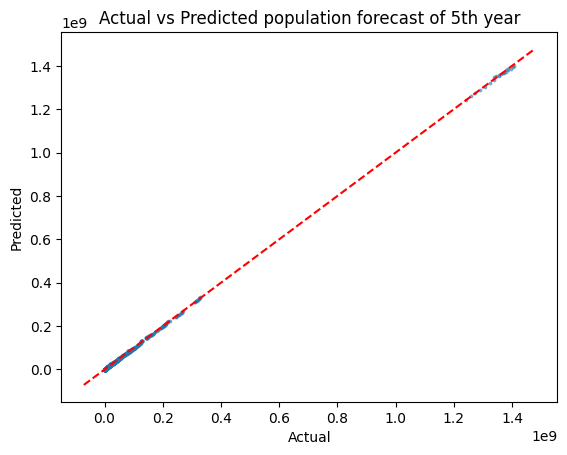

In [112]:
#Plotting 5th year forecast
fig,ax=plt.subplots()
ax.scatter(actual_population_5,predicted_population_5,s=3,alpha=0.5)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'r--')

plt.title('Actual vs Predicted population forecast of 5th year')
plt.xlabel('Actual')
plt.ylabel('Predicted')

Text(0, 0.5, 'Predicted')

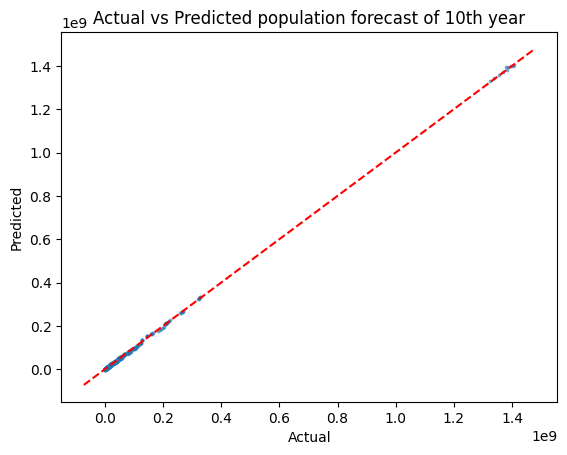

In [113]:
#Plotting 10th year forecast
fig,ax=plt.subplots()
ax.scatter(actual_population_10,predicted_population_10,s=3,alpha=0.5)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'r--')

plt.title('Actual vs Predicted population forecast of 10th year')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [114]:
mape_lstm_general_5=metrics.mean_absolute_percentage_error(actual_population_5,predicted_population_5)
mape_lstm_general_10=metrics.mean_absolute_percentage_error(actual_population_10,predicted_population_10)
df_metrics['LSTM General model']=[mape_lstm_general_5,mape_lstm_general_10]
df_metrics

,Basemodel,Arima model,LSTM Model,LSTM General model
Prediction 5th,0.008479,0.003206,0.001595,1.271667
Prediction 10th,0.012140,0.006591,0.004503,2.086677


We observe that when generalizing the model, the performance is worse than when using on single data

This is expected because now the model is working on various scale of population , instead of a similar scale when used for only one country

In [115]:
df_general=pd.DataFrame({'LSTM General 5':[mape_lstm_general_5,mape_lstm_general_10]},index=['Prediction 5th','Prediction 10th'])
df_general

,LSTM General 5
Prediction 5th,1.271667
Prediction 10th,2.086677


## Using the same model but with 10 years of input

In [116]:
#Creating  datasets for 5th year prediction with 10 previous years of data
train_X_5_10,train_Y_5_10 = create_dataset_country(df_train_total_scaled,input_width=10,delay=5,country_column='Country Name',year_column='Year',target='Population, total')
test_X_5_10,test_Y_5_10 = create_dataset_country(df_test_total_scaled,input_width=10,delay=5,country_column='Country Name',year_column='Year',target='Population, total')

#Creating  datasets for 10th year prediction with 10 previous years of data
train_X_10_10,train_Y_10_10 = create_dataset_country(df_train_total_scaled,input_width=10,delay=5,country_column='Country Name',year_column='Year',target='Population, total')
test_X_10_10,test_Y_10_10 = create_dataset_country(df_test_total_scaled,input_width=10,delay=5,country_column='Country Name',year_column='Year',target='Population, total')

#Shuffling only the train dataset
train_X_5_10,train_Y_5_10  = shuffle_dataset(train_X_5_10,train_Y_5_10 )
train_X_10_10,train_Y_10_10 = shuffle_dataset(train_X_10_10,train_Y_10_10)

In [117]:
#Predicting value for 5th year with 10 years of input
model_lstm_5_10=lstm_model_general(train_X_5_10,train_Y_5_10,test_X_5_10,test_Y_5_10,shape=(10,17),epoch=300,batch_size=128)

Epoch 1/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0113 - mae: 0.0675 - val_loss: 0.0094 - val_mae: 0.0273
Epoch 2/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0040 - mae: 0.0233 - val_loss: 0.0071 - val_mae: 0.0263
Epoch 3/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0027 - mae: 0.0217 - val_loss: 0.0044 - val_mae: 0.0234
Epoch 4/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017 - mae: 0.0171 - val_loss: 0.0018 - val_mae: 0.0183
Epoch 5/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.4462e-04 - mae: 0.0131 - val_loss: 1.5741e-04 - val_mae: 0.0092
Epoch 6/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.0559e-04 - mae: 0.0073 - val_loss: 8.7441e-05 - val_mae: 0.0050
Epoch 7/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.8773e-05 - mae: 0.0045 - val_loss: 1.0889e-04 - val_mae: 0.0051
Epoch 8/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.7816e-05 - mae: 0.0037 - val_loss: 9.3411e-05 - val_mae: 0.0043
Epoch 9/300
28/28 ━━━━━━

In [118]:
#Predicting value for 10th year with 10 years of input
model_lstm_10_10=lstm_model_general(train_X_10_10,train_Y_10_10,test_X_10_10,test_Y_10_10,shape=(10,17),epoch=300,batch_size=128)

Epoch 1/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0122 - mae: 0.0690 - val_loss: 0.0097 - val_mae: 0.0275
Epoch 2/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0027 - mae: 0.0230 - val_loss: 0.0077 - val_mae: 0.0339
Epoch 3/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0036 - mae: 0.0231 - val_loss: 0.0054 - val_mae: 0.0266
Epoch 4/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0019 - mae: 0.0181 - val_loss: 0.0031 - val_mae: 0.0251
Epoch 5/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0011 - mae: 0.0161 - val_loss: 0.0010 - val_mae: 0.0163
Epoch 6/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7888e-04 - mae: 0.0121 - val_loss: 1.3388e-04 - val_mae: 0.0080
Epoch 7/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 8.6964e-05 - mae: 0.0060 - val_loss: 6.9084e-05 - val_mae: 0.0042
Epoch 8/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.2915e-05 - mae: 0.0033 - val_loss: 9.8345e-05 - val_mae: 0.0041
Epoch 9/300
28/28 ━━━━━━━━━━━━━━

In [119]:
predicted_values_5_10=model_lstm_5_10.predict(test_X_5_10)

predicted_values_10_10=model_lstm_10_10.predict(test_X_10_10)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [120]:
#Inverse scaling
predicted_population_5_10=inverse_transform(predicted_values_5_10,mscaler,'Population, total')  #Predicted 5th year
actual_population_5_10=inverse_transform(test_Y_5_10,mscaler,'Population, total')               #Actual 5th year

predicted_population_10_10=inverse_transform(predicted_values_10_10,mscaler,'Population, total')  #Predicted 5th year
actual_population_10_10=inverse_transform(test_Y_10_10,mscaler,'Population, total')               #Actual 5th year


In [121]:
mape_lstm_general_5_10=metrics.mean_absolute_percentage_error(actual_population_5_10,predicted_population_5_10)
mape_lstm_general_10_10=metrics.mean_absolute_percentage_error(actual_population_10_10,predicted_population_10_10)
df_general['LSTM General model 10']=[mape_lstm_general_5_10,mape_lstm_general_10_10]
df_general

,LSTM General 5,LSTM General model 10
Prediction 5th,1.271667,3.205683
Prediction 10th,2.086677,1.856618


## Using the same model but with progressive years of input

In [122]:
#Defining a function to create dataset which  can take different lengths of input
def create_dataset_irregular(dataset,min_input_width,delay=0,country_column='Country Name',year_column='Year',target='Population, total'):
    data_X, data_Y = [], []
    #min_input_width specifies the min input width of previous data  
    window_size= min_input_width+delay    #delay specifies after how many data pints from input width will output prediction be made

    for j in dataset[country_column].unique():   #Selecting the country
          data_country=dataset[dataset[country_column]==j]         #Selecting a dataset by country
          data_country=data_country.sort_values(by=year_column,ascending=True)
          data_country=data_country.drop([country_column,year_column],axis=1)   #Dropping the first 2 columns
          data_country=data_country.reset_index(drop=True)                   #Resetting the index


          for i in range(len(data_country) - window_size+1):  #index upto which input is taken
              data_X.append(data_country.loc[0:(i + min_input_width-1), :])  #Using data from 1st observation upto window size,which progressively increases
              data_Y.append(data_country.loc[(i + min_input_width+delay-1), target])
                


    return(data_X,np.array(data_Y))   #returns the non-uniform array list along with target array

In [123]:
#Creating a function for padding
def pad_array(array_list,max_seq,mask_value=-999):

    padded_array = []
    for arr in array_list:
        
        pad_rows = max_seq - arr.shape[0]     #No of cells in array to be padded 
            
        #-999 is used because all values will be between 0 and 1, inclusive, can be easily masked later
        #only rows are poadded at the end
        
        padded_arr = np.pad(arr, ((0, pad_rows),(0,0)), mode='constant', constant_values=mask_value)
        padded_array.append(padded_arr)

    final_array=np.array(padded_array)

    return final_array

In [124]:
#Creating  datasets for 5th year prediction with min 2 years of data
train_X_5_ir_array,train_Y_5_ir = create_dataset_irregular(df_train_total_scaled,min_input_width=2,delay=5,country_column='Country Name',year_column='Year',target='Population, total')
test_X_5_ir_array,test_Y_5_ir = create_dataset_irregular(df_test_total_scaled,min_input_width=2,delay=5,country_column='Country Name',year_column='Year',target='Population, total')


In [125]:
#Creating  datasets for 10th year prediction with min 2 years of data
train_X_10_ir_array,train_Y_10_ir = create_dataset_irregular(df_train_total_scaled,min_input_width=2,delay=10,country_column='Country Name',year_column='Year',target='Population, total')
test_X_10_ir_array,test_Y_10_ir = create_dataset_irregular(df_test_total_scaled,min_input_width=2,delay=10,country_column='Country Name',year_column='Year',target='Population, total')


In [126]:
#Checking max length of sequence for 5 years prediction
max_seq=max([arr.shape[0] for arr in train_X_5_ir_array])
max_seq
            

40

In [127]:
#Checking max length of sequence for 10 years prediction
max_seq=max([arr.shape[0] for arr in train_X_10_ir_array])
max_seq

35

In [128]:
#Padding the array list
train_X_5_ir=pad_array(train_X_5_ir_array,40)
test_X_5_ir=pad_array(test_X_5_ir_array,40)

train_X_10_ir=pad_array(train_X_10_ir_array,35)
test_X_10_ir=pad_array(test_X_10_ir_array,35)

#Shuffling only the train dataset
train_X_5_ir,train_Y_5_ir  = shuffle_dataset(train_X_5_ir,train_Y_5_ir )
train_X_10_ir,train_Y_10_ir  = shuffle_dataset(train_X_10_ir,train_Y_10_ir )

In [129]:
#Checking length of X train
print(f'Shape of X train 5:{train_X_5_ir.shape}')
print(f'Shape of X test 5:{test_X_5_ir.shape}')

print(f'Shape of X train 10:{train_X_10_ir.shape}')
print(f'Shape of X test 10:{test_X_10_ir.shape}')

Shape of X train 5:(5039, 40, 17)
Shape of X test 5:(2483, 40, 17)
Shape of X train 10:(4086, 35, 17)
Shape of X test 10:(1528, 35, 17)


In [130]:
from keras.layers import InputLayer,LSTM,Dense,Masking
from keras.models import Model

In [131]:
def lstm_model_irregular(train_X,train_Y,test_X,test_Y,shape=(40,17),epoch=300,batch_size=64):
  input=Input(shape=shape)

  masked_layer=Masking(mask_value=-999)(input)

  x=LSTM(1024,return_sequences=True)(masked_layer)
    
  x=LSTM(1024)(x)

  output=Dense(1)(x)

  model = Model(input, output)

  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.001), loss="mse", metrics=["mae"])

  callback=keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True)

  history=model.fit(x=train_X,y=train_Y,epochs=epoch,validation_data=[test_X,test_Y],batch_size=batch_size,callbacks=[callback])

  

  return model

In [132]:
#Predicting value for 5th year with min 2 years of input
model_lstm_5_ir=lstm_model_irregular(train_X_5_ir,train_Y_5_ir,test_X_5_ir,test_Y_5_ir,shape=(40,17),epoch=300,batch_size=64)

Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.4620 - mae: 0.2217 - val_loss: 0.0097 - val_mae: 0.0325
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0040 - mae: 0.0247 - val_loss: 0.0066 - val_mae: 0.0280
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0024 - mae: 0.0203 - val_loss: 0.0035 - val_mae: 0.0219
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0015 - mae: 0.0158 - val_loss: 0.0027 - val_mae: 0.0172
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7.2847e-04 - mae: 0.0102 - val_loss: 0.0022 - val_mae: 0.0142
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 3.9311e-04 - mae: 0.0080 - val_loss: 0.0019 - val_mae: 0.0138
Epoch 7/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.6749e-04 - mae: 0.0080 - val_loss: 0.0018 - val_mae: 0.0121
Epoch 8/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.3230e-04 - mae: 0.0070 - val_loss: 0.0016 - val_mae: 0.0115
Epoch 9/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3

In [133]:
#Predicting value for 10th year with min 2 years of input
model_lstm_10_ir=lstm_model_irregular(train_X_10_ir,train_Y_10_ir,test_X_10_ir,test_Y_10_ir,shape=(35,17),epoch=300,batch_size=64)

Epoch 1/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.3837 - mae: 0.2279 - val_loss: 0.0110 - val_mae: 0.0401
Epoch 2/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0046 - mae: 0.0268 - val_loss: 0.0091 - val_mae: 0.0305
Epoch 3/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0036 - mae: 0.0232 - val_loss: 0.0067 - val_mae: 0.0258
Epoch 4/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0024 - mae: 0.0187 - val_loss: 0.0049 - val_mae: 0.0224
Epoch 5/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011 - mae: 0.0115 - val_loss: 0.0041 - val_mae: 0.0192
Epoch 6/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.3630e-04 - mae: 0.0087 - val_loss: 0.0036 - val_mae: 0.0180
Epoch 7/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.4649e-04 - mae: 0.0089 - val_loss: 0.0030 - val_mae: 0.0160
Epoch 8/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 6.6118e-04 - mae: 0.0073 - val_loss: 0.0026 - val_mae: 0.0145
Epoch 9/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36

In [134]:
predicted_values_5_ir=model_lstm_5_ir.predict(test_X_5_ir)[:,0]
predicted_values_10_ir=model_lstm_10_ir.predict(test_X_10_ir)[:,0]

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [135]:
#Inverse scaling
predicted_population_5_ir=inverse_transform(predicted_values_5_ir,mscaler,'Population, total')  #Predicted 5th year
actual_population_5_ir=inverse_transform(test_Y_5_ir,mscaler,'Population, total')               #Actual 5th year

predicted_population_10_ir=inverse_transform(predicted_values_10_ir,mscaler,'Population, total')  #Predicted 5th year
actual_population_10_ir=inverse_transform(test_Y_10_ir,mscaler,'Population, total')               #Actual 5th year

In [136]:
mape_lstm_general_5_ir=metrics.mean_absolute_percentage_error(actual_population_5_ir,predicted_population_5_ir)
mape_lstm_general_10_ir=metrics.mean_absolute_percentage_error(actual_population_10_ir,predicted_population_10_ir)
df_general['LSTM General model ir']=[mape_lstm_general_5_ir,mape_lstm_general_10_ir]
df_general

,LSTM General 5,LSTM General model 10,LSTM General model ir
Prediction 5th,1.271667,3.205683,0.788561
Prediction 10th,2.086677,1.856618,1.979409


We can see that our model with progressive data using data from all previous years gives the best prediction


**In all the above models, we have used Population as target, but as the evaluation metric is Absolute error, using Population as target will result in optimizing the model for those countries which have higher population.For more robust models and to eliminate the effect of scale of population, it is better to use Population Growth with respect to current population as our target**


# Predicting Population with population Growth as target

In [137]:
selected_columns=df_train_total_scaled.columns
selected_columns_num=['Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old', 'Age dependency ratio, young',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'Mortality rate, neonatal (per 1,000 live births)',
       'Mortality rate, under-5 (per 1,000)', 'Net migration',
       'Population ages 0-14 (% of total population)',
       'Population ages 65 and above (% of total population)',
       'Population growth (annual %)', 'Population, total',
       'Urban population (% of total population)',
       'Urban population growth (annual %)']

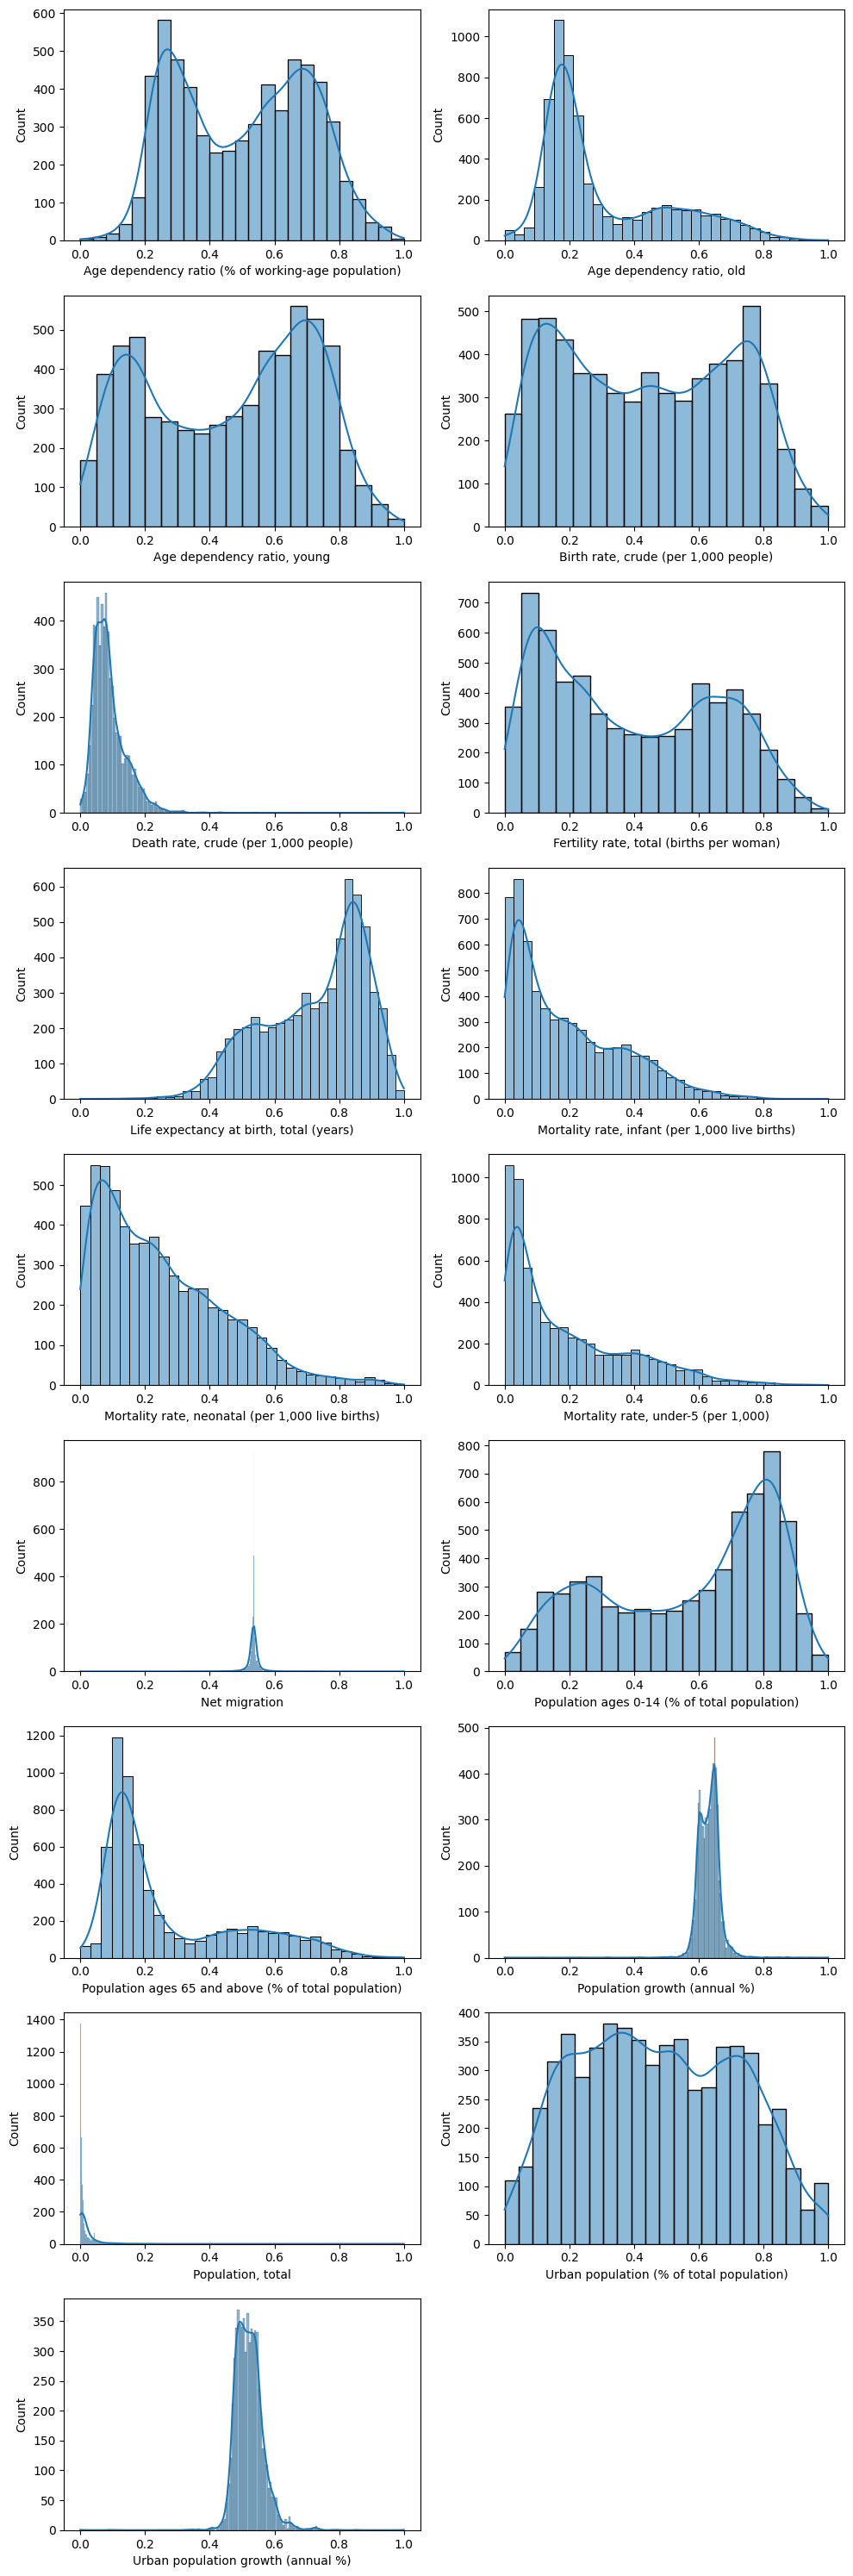

In [138]:
#Checking distribution of scaled columns
plt.figure(figsize=(10,30))
for i,j in enumerate(selected_columns_num):
  ax=plt.subplot(9,2,i+1)
  sns.histplot(df_train_total_scaled[j],ax=ax,kde=True)
  plt.xlabel(j)
plt.tight_layout()

Checking the histograms of all data, we can clearly observe that Population data is highly skewed towards 0, ie most population is at the lower end of the data

In [139]:
#Defining a function to create dataset which  can take different lengths of input
def create_dataset_irregular_growth(dataset_scaled,dataset_unscaled,min_input_width,delay=0,country_column='Country Name',year_column='Year',target='Population, total'):
    data_X, data_Y, target_pop_list,last_year_pop_list = [], [], [], []
    #min_input_width specifies the min input width of previous data  
    window_size= min_input_width+delay    #delay specifies after how many data pints from input width will output prediction be made

    for j in dataset_scaled[country_column].unique():   #Selecting the country
          data_country=dataset_scaled[dataset_scaled[country_column]==j]         #Selecting a dataset by country
          data_country=data_country.sort_values(by=year_column,ascending=True)
          data_country=data_country.drop([country_column,year_column],axis=1)   #Dropping the first 2 columns
          data_country=data_country.reset_index(drop=True)                   #Resetting the index
        
          data_country_unscaled=dataset_unscaled[dataset_unscaled[country_column]==j]         #Selecting a dataset by country
          data_country_unscaled=data_country_unscaled.sort_values(by=year_column,ascending=True)
          data_country_unscaled=data_country_unscaled.drop([country_column,year_column],axis=1)   #Dropping the first 2 columns
          data_country_unscaled=data_country_unscaled.reset_index(drop=True)


          for i in range(len(data_country) - window_size+1):  #index upto which input is taken
              data_X.append(data_country.loc[0:(i + min_input_width-1), :])  #Using data from 1st observation upto window size
            
              #Calculating the growth
              #growth=(target_pop-last_year_pop)/last_year_pop
              target_pop=data_country_unscaled.loc[(i + min_input_width+delay-1), target]
              last_year_pop=data_country_unscaled.loc[(i + min_input_width-1), target]
              growth=(target_pop-last_year_pop)/last_year_pop

              data_Y.append(growth)
              
              target_pop_list.append(target_pop)
              last_year_pop_list.append(last_year_pop)
              
                

    return(data_X,np.array(data_Y),np.array(target_pop_list),np.array(last_year_pop_list))   #returns the non-uniform array list along with target array

In [140]:
#Creating  datasets for 5th year prediction with min 2 years of data
train_X_5_growth_array,train_Y_5_growth,_,_ = create_dataset_irregular_growth(df_train_total_scaled,df_train_total,min_input_width=2,delay=5,country_column='Country Name',year_column='Year',target='Population, total')
test_X_5_growth_array,test_Y_5_growth,target_pop_5,last_year_pop_5 = create_dataset_irregular_growth(df_test_total_scaled,df_test_total,min_input_width=2,delay=5,country_column='Country Name',year_column='Year',target='Population, total')

#Creating  datasets for 10th year prediction with min 2 years of data
train_X_10_growth_array,train_Y_10_growth,_,_ = create_dataset_irregular_growth(df_train_total_scaled,df_train_total,min_input_width=2,delay=10,country_column='Country Name',year_column='Year',target='Population, total')
test_X_10_growth_array,test_Y_10_growth,target_pop_10,last_year_pop_10 = create_dataset_irregular_growth(df_test_total_scaled,df_test_total,min_input_width=2,delay=10,country_column='Country Name',year_column='Year',target='Population, total')

In [141]:
#Checking max length of sequence for 5 years prediction
max_seq_5=max([arr.shape[0] for arr in train_X_5_growth_array])
max_seq_10=max([arr.shape[0] for arr in train_X_10_growth_array])

#Padding the array list
train_X_5_growth=pad_array(train_X_5_growth_array,max_seq_5)
test_X_5_growth=pad_array(test_X_5_growth_array,max_seq_5)

train_X_10_growth=pad_array(train_X_10_growth_array,max_seq_10)
test_X_10_growth=pad_array(test_X_10_growth_array,max_seq_10)

#Shuffling only the train dataset
train_X_5_growth,train_Y_5_growth  = shuffle_dataset(train_X_5_growth,train_Y_5_growth)
train_X_10_growth,train_Y_10_growth  = shuffle_dataset(train_X_10_growth,train_Y_10_growth )
         

In [142]:
def lstm_model_irregular_growth(train_X,train_Y,test_X,test_Y,shape=(40,17),epoch=300,batch_size=64):
  input=Input(shape=shape)

  masked_layer=Masking(mask_value=-999)(input)

  x=LSTM(1024,return_sequences=True)(masked_layer)
    
  x=LSTM(1024)(x)

  output=Dense(1)(x)

  model = Model(input, output)

  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.001), loss="mse", metrics=["mae"])

  callback=keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True)

  history=model.fit(x=train_X,y=train_Y,epochs=epoch,validation_data=[test_X,test_Y],batch_size=batch_size,callbacks=[callback])

  

  return model

In [143]:
#Predicting value for 5th year with min 2 years of input
model_lstm_5_growth=lstm_model_irregular_growth(train_X_5_growth,train_Y_5_growth,test_X_5_growth,test_Y_5_growth,shape=(40,17),epoch=300,batch_size=64)

Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.2842 - mae: 0.2076 - val_loss: 0.0074 - val_mae: 0.0458
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0030 - mae: 0.0361 - val_loss: 0.0066 - val_mae: 0.0409
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0024 - mae: 0.0320 - val_loss: 0.0062 - val_mae: 0.0391
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0026 - mae: 0.0317 - val_loss: 0.0060 - val_mae: 0.0387
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0023 - mae: 0.0306 - val_loss: 0.0059 - val_mae: 0.0378
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0022 - mae: 0.0290 - val_loss: 0.0057 - val_mae: 0.0375
Epoch 7/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0023 - mae: 0.0295 - val_loss: 0.0055 - val_mae: 0.0368
Epoch 8/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0020 - mae: 0.0280 - val_loss: 0.0056 - val_mae: 0.0377
Epoch 9/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - lo

In [144]:
#Predicting value for 10th year with min 2 years of input
model_lstm_10_growth=lstm_model_irregular_growth(train_X_10_growth,train_Y_10_growth,test_X_10_growth,test_Y_10_growth,shape=(35,17),epoch=300,batch_size=64)


Epoch 1/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.5812 - mae: 0.3051 - val_loss: 0.0298 - val_mae: 0.0957
Epoch 2/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0116 - mae: 0.0705 - val_loss: 0.0267 - val_mae: 0.0865
Epoch 3/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0096 - mae: 0.0647 - val_loss: 0.0258 - val_mae: 0.0847
Epoch 4/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0085 - mae: 0.0619 - val_loss: 0.0254 - val_mae: 0.0848
Epoch 5/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0087 - mae: 0.0619 - val_loss: 0.0251 - val_mae: 0.0847
Epoch 6/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0087 - mae: 0.0609 - val_loss: 0.0245 - val_mae: 0.0835
Epoch 7/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0079 - mae: 0.0594 - val_loss: 0.0240 - val_mae: 0.0826
Epoch 8/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0074 - mae: 0.0579 - val_loss: 0.0234 - val_mae: 0.0810
Epoch 9/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - lo

In [145]:
#Predicting the growth 
predicted_growth_5_ir=model_lstm_5_growth.predict(test_X_5_growth)[:,0]
predicted_growth_10_ir=model_lstm_10_growth.predict(test_X_10_growth)[:,0]

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [146]:
#Predicting population from growth data
predicted_population_growth_5=predicted_growth_5_ir*last_year_pop_5+last_year_pop_5

predicted_population_growth_10=predicted_growth_10_ir*last_year_pop_10+last_year_pop_10

In [147]:
mape_lstm_general_5_growth=metrics.mean_absolute_percentage_error(target_pop_5,predicted_population_growth_5)
mape_lstm_general_10_growth=metrics.mean_absolute_percentage_error(target_pop_10,predicted_population_growth_10)
df_general['LSTM General model Growth']=[mape_lstm_general_5_growth,mape_lstm_general_10_growth]
df_general

,LSTM General 5,LSTM General model 10,LSTM General model ir,LSTM General model Growth
Prediction 5th,1.271667,3.205683,0.788561,0.027852
Prediction 10th,2.086677,1.856618,1.979409,0.055260


From the above table, we can see that LSTM Model with progressive data and target set as population growth gives the best predictions

Text(0, 0.5, 'Predicted growth')

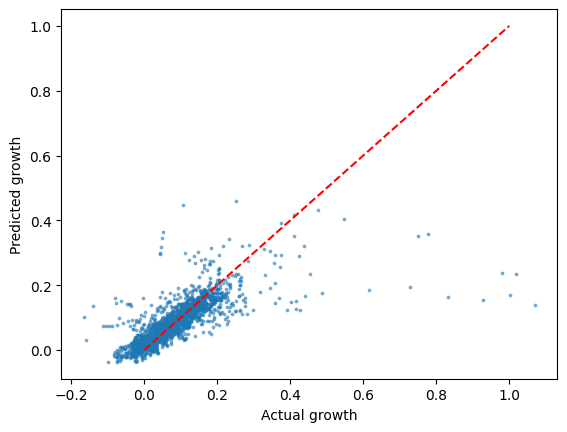

In [148]:
#Plotting population growth
plt.scatter(test_Y_5_growth,predicted_growth_5_ir,s=3,alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Actual growth')
plt.ylabel('Predicted growth')

Text(0, 0.5, 'Predicted growth')

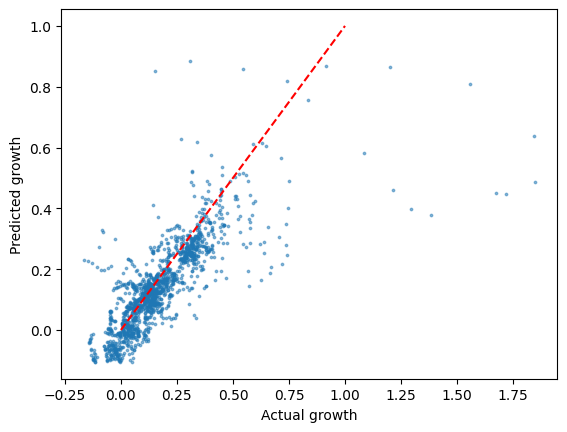

In [149]:
#Plotting population growth
plt.scatter(test_Y_10_growth,predicted_growth_10_ir,s=3,alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Actual growth')
plt.ylabel('Predicted growth')

## Using Bi-directional LSTM model

In [150]:
def lstm_model_bi_growth(train_X,train_Y,test_X,test_Y,shape=(40,17),epoch=300,batch_size=64):
  input=Input(shape=shape)

  masked_layer=Masking(mask_value=-999)(input)

  x=Bidirectional(LSTM(1024,return_sequences=True))(masked_layer)
    
  x=Bidirectional(LSTM(1024))(x)

  output=Dense(1)(x)

  model = Model(input, output)

  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.001), loss="mse", metrics=["mae"])

  callback=keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True)

  history=model.fit(x=train_X,y=train_Y,epochs=epoch,validation_data=[test_X,test_Y],batch_size=batch_size,callbacks=[callback])

  

  return model

In [151]:
#Predicting value for 5th year with min 2 years of input
model_lstm_5_growth_bi=lstm_model_bi_growth(train_X_5_growth,train_Y_5_growth,test_X_5_growth,test_Y_5_growth,shape=(40,17),epoch=300,batch_size=64)

Epoch 1/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 1.4869 - mae: 0.4098 - val_loss: 0.0087 - val_mae: 0.0556
Epoch 2/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0033 - mae: 0.0389 - val_loss: 0.0070 - val_mae: 0.0447
Epoch 3/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0028 - mae: 0.0351 - val_loss: 0.0064 - val_mae: 0.0411
Epoch 4/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0024 - mae: 0.0330 - val_loss: 0.0061 - val_mae: 0.0392
Epoch 5/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0023 - mae: 0.0310 - val_loss: 0.0059 - val_mae: 0.0384
Epoch 6/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0023 - mae: 0.0307 - val_loss: 0.0059 - val_mae: 0.0388
Epoch 7/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0021 - mae: 0.0292 - val_loss: 0.0057 - val_mae: 0.0377
Epoch 8/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0020 - mae: 0.0290 - val_loss: 0.0056 - val_mae: 0.0369
Epoch 9/300
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step -

In [152]:
#Predicting value for 10th year with min 2 years of input
model_lstm_10_growth_bi=lstm_model_bi_growth(train_X_10_growth,train_Y_10_growth,test_X_10_growth,test_Y_10_growth,shape=(35,17),epoch=300,batch_size=64)

Epoch 1/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 1.7140 - mae: 0.5087 - val_loss: 0.0360 - val_mae: 0.1154
Epoch 2/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0134 - mae: 0.0769 - val_loss: 0.0282 - val_mae: 0.0908
Epoch 3/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0100 - mae: 0.0681 - val_loss: 0.0264 - val_mae: 0.0853
Epoch 4/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0086 - mae: 0.0633 - val_loss: 0.0255 - val_mae: 0.0830
Epoch 5/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0095 - mae: 0.0642 - val_loss: 0.0253 - val_mae: 0.0833
Epoch 6/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0078 - mae: 0.0594 - val_loss: 0.0249 - val_mae: 0.0834
Epoch 7/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0076 - mae: 0.0589 - val_loss: 0.0248 - val_mae: 0.0839
Epoch 8/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0081 - mae: 0.0602 - val_loss: 0.0244 - val_mae: 0.0835
Epoch 9/300
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - l

In [153]:
#Predicting the growth 
predicted_growth_5_bi=model_lstm_5_growth_bi.predict(test_X_5_growth)[:,0]
predicted_growth_10_bi=model_lstm_10_growth_bi.predict(test_X_10_growth)[:,0]

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [154]:
#Predicting population from growth data
predicted_population_growth_5_bi=predicted_growth_5_bi*last_year_pop_5+last_year_pop_5

predicted_population_growth_10_bi=predicted_growth_10_bi*last_year_pop_10+last_year_pop_10

In [155]:
mape_lstm_general_5_growth_bi=metrics.mean_absolute_percentage_error(target_pop_5,predicted_population_growth_5_bi)
mape_lstm_general_10_growth_bi=metrics.mean_absolute_percentage_error(target_pop_10,predicted_population_growth_10_bi)
df_general['LSTM Bidirectional  Growth']=[mape_lstm_general_5_growth_bi,mape_lstm_general_10_growth_bi]
df_general

,LSTM General 5,LSTM General model 10,LSTM General model ir,LSTM General model Growth,LSTM Bidirectional Growth
Prediction 5th,1.271667,3.205683,0.788561,0.027852,0.027413
Prediction 10th,2.086677,1.856618,1.979409,0.055260,0.057329


Bi-directional model does not seem to improve performance by any significant margin, hence we will try to ture LSTM Model



## Tuning the  LSTM Model

In [156]:
def lstm_model_final(train_X,train_Y,test_X,test_Y,masking=-999,epoch=300,batch_size=64):
  
  shape=train_X.shape[1:]
    
  input=Input(shape=shape)

  masked_layer=Masking(mask_value=masking)(input)

  x=LSTM(1024,return_sequences=True)(masked_layer)

  x=LSTM(1024,return_sequences=True)(x)
   
  x=LSTM(1024)(x)

  output=Dense(1)(x)

  model = Model(input, output)

  model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.0003), loss="mse", metrics=["mae"])  #Used a lower learning rate

  callback=keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)     #Increased the patience


  history=model.fit(x=train_X,y=train_Y,epochs=epoch,validation_data=[test_X,test_Y],batch_size=batch_size,callbacks=[callback])

  

  return model

In [157]:
#Predicting value for 5th year with min 2 years of input
model_lstm_final_5=lstm_model_final(train_X_5_growth,train_Y_5_growth,test_X_5_growth,test_Y_5_growth,masking=-999,epoch=500,batch_size=128)

Epoch 1/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0536 - mae: 0.1294 - val_loss: 0.0079 - val_mae: 0.0498
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0037 - mae: 0.0403 - val_loss: 0.0073 - val_mae: 0.0461
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0030 - mae: 0.0366 - val_loss: 0.0070 - val_mae: 0.0444
Epoch 4/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0030 - mae: 0.0363 - val_loss: 0.0069 - val_mae: 0.0439
Epoch 5/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0028 - mae: 0.0343 - val_loss: 0.0067 - val_mae: 0.0436
Epoch 6/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0027 - mae: 0.0339 - val_loss: 0.0066 - val_mae: 0.0432
Epoch 7/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0024 - mae: 0.0326 - val_loss: 0.0064 - val_mae: 0.0418
Epoch 8/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0025 - mae: 0.0324 - val_loss: 0.0063 - val_mae: 0.0417
Epoch 9/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - lo

In [158]:
#Predicting value for 10th year with min 2 years of input
model_lstm_final_10=lstm_model_final(train_X_10_growth,train_Y_10_growth,test_X_10_growth,test_Y_10_growth,masking=-999,epoch=500,batch_size=128)

Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0649 - mae: 0.1758 - val_loss: 0.0363 - val_mae: 0.1128
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0148 - mae: 0.0828 - val_loss: 0.0326 - val_mae: 0.1027
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0119 - mae: 0.0733 - val_loss: 0.0308 - val_mae: 0.0979
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0112 - mae: 0.0711 - val_loss: 0.0296 - val_mae: 0.0955
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0112 - mae: 0.0711 - val_loss: 0.0288 - val_mae: 0.0938
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0100 - mae: 0.0679 - val_loss: 0.0276 - val_mae: 0.0909
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0096 - mae: 0.0666 - val_loss: 0.0271 - val_mae: 0.0900
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0101 - mae: 0.0663 - val_loss: 0.0267 - val_mae: 0.0895
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - lo

In [159]:
#Predicting the growth 
predicted_growth_5_final=model_lstm_final_5.predict(test_X_5_growth)[:,0]
predicted_growth_10_final=model_lstm_final_10.predict(test_X_10_growth)[:,0]

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [160]:
#Predicting population from growth data
predicted_population_final_5=predicted_growth_5_final*last_year_pop_5+last_year_pop_5

predicted_population_final_10=predicted_growth_10_final*last_year_pop_10+last_year_pop_10

In [161]:
mape_lstm_final_5=metrics.mean_absolute_percentage_error(target_pop_5,predicted_population_final_5)
mape_lstm_final_10=metrics.mean_absolute_percentage_error(target_pop_10,predicted_population_final_10)
df_general['LSTM Final']=[mape_lstm_final_5,mape_lstm_final_10]
df_general

,LSTM General 5,LSTM General model 10,LSTM General model ir,LSTM General model Growth,LSTM Bidirectional Growth,LSTM Final
Prediction 5th,1.271667,3.205683,0.788561,0.027852,0.027413,0.028161
Prediction 10th,2.086677,1.856618,1.979409,0.055260,0.057329,0.054707


**Hence, the  LSTM model is predicting with mean average percentage error  of  2.8% for 5th year prediction and 5.5% for 10th year prediction**

In [162]:
#Saving model in current dir
model_lstm_final_5.save('population_estimate_5th.keras')
model_lstm_final_10.save('population_estimate_10th.keras')

## Predicting the output

In [163]:
#Defining a function to take input a country and year list

def data_extract(dataframe,country,year_list):
    df_country=df_test_total[df_test_total['Country Name']==country] #Selects the country
    df_selected=df_country[df_country['Year'].isin(year_list)]       # Selects the year

    
    last_year=year_list[-1]
    target_year_5=last_year+5
    target_year_10=last_year+10

    pop_last_year=df_country[df_country['Year']==last_year]['Population, total'].values[0]
    pop_target_5=df_country[df_country['Year']==target_year_5]['Population, total'].values[0]
    pop_target_10=df_country[df_country['Year']==target_year_10]['Population, total'].values[0]

    return df_selected,pop_last_year,pop_target_5,pop_target_10

In [164]:
#List of selected features used during prediction
selected_columns_num=['Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old', 'Age dependency ratio, young',
       'Birth rate, crude (per 1,000 people)',
       'Death rate, crude (per 1,000 people)',
       'Fertility rate, total (births per woman)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'Mortality rate, neonatal (per 1,000 live births)',
       'Mortality rate, under-5 (per 1,000)', 'Net migration',
       'Population ages 0-14 (% of total population)',
       'Population ages 65 and above (% of total population)',
       'Population growth (annual %)', 'Population, total',
       'Urban population (% of total population)',
       'Urban population growth (annual %)']

In [165]:
#Creating a function for padding given an array
def pad_array_test(array,max_seq,mask_value=-999):
 
        
    pad_rows = max_seq - array.shape[0]     #No of cells in array to be padded 

    #-999 is used because all values will be between 0 and 1, inclusive, can be easily masked later
    #only rows are poadded at the end

    padded_arr = np.pad(array, ((0, pad_rows),(0,0)), mode='constant', constant_values=mask_value)
   

    return padded_arr

In [166]:
#Creating the data and selecting target years
df_data,pop_last_year,pop_target_5,pop_target_10=data_extract(df_train_total,'Bangladesh',[2005,2006,2007,2008,2009])


In [167]:
#Scaling data
df_data_scaled=mscaler.transform(df_data[selected_columns_num])

#Padding data for 5th year
data_padded_5=pad_array_test(df_data_scaled,max_seq=40,mask_value=-999)
data_padded_5=data_padded_5.reshape(-1,40,17)

#Padding data for 10th year
data_padded_10=pad_array_test(df_data_scaled,max_seq=35,mask_value=-999)
data_padded_10=data_padded_10.reshape(-1,35,17)


In [168]:
#Predicting growth
pred_growth_5=model_lstm_final_5.predict(data_padded_5)[:,0][0]
pred_growth_10=model_lstm_final_10.predict(data_padded_10)[:,0][0]

#Predicting population from growth data
pred_population_5=pred_growth_5*pop_last_year+pop_last_year
pred_population_10=pred_growth_10*pop_last_year+pop_last_year

#Creating a dataframe to dispaly the result
df_result=pd.DataFrame({'Predicted':[np.round(pred_population_5,0),np.round(pred_population_10,0)],'Actual':[pop_target_5,pop_target_10]},index=['5th year','10th year'])
df_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,Predicted,Actual
5th year,155382660.0,155961299.0
10th year,163845783.0,165516222.0


In [173]:
#Defining a function to input a dataframe containing selected columns and outputting result
def predict_population(df,current_population,scaler,selected_columns_num,model_5,model_10):
    #Scaling data
    df_data_scaled=scaler.transform(df_data[selected_columns_num])
    
    #Padding data for 5th year
    data_padded_5=pad_array_test(df_data_scaled,max_seq=40,mask_value=-999)
    data_padded_5=data_padded_5.reshape(-1,40,17)
    
    #Padding data for 10th year
    data_padded_10=pad_array_test(df_data_scaled,max_seq=35,mask_value=-999)
    data_padded_10=data_padded_10.reshape(-1,35,17)

    #Predicting growth
    pred_growth_5=model_lstm_final_5.predict(data_padded_5)[:,0][0]
    pred_growth_10=model_lstm_final_10.predict(data_padded_10)[:,0][0]
    
    #Predicting population from growth data
    pred_population_5=pred_growth_5*current_population+current_population
    pred_population_10=pred_growth_10*current_population+current_population
    
    #Creating a dataframe to dispaly the result
    print(f"Estimated population of 5th year:{int(pred_population_5)} \nEstimated population of 10th year:{int(pred_population_10)}")

    return int(pred_population_5),int(pred_population_10)
  

In [174]:
#Predicting 5th and 10th year population based on a dataframe containing feature information
predict_population(df_data,current_population=pop_last_year,scaler=mscaler,selected_columns_num=selected_columns_num,
                   model_5=model_lstm_final_5,model_10=model_lstm_final_10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Estimated population of 5th year:155382660 
Estimated population of 10th year:163845782


(155382660, 163845782)

# Summary

The population estimate model worked best when using a multi-layer LSTM architecture, that takes multiple demographic features as input, and can produce prediction for future population with mean error rate of 2% for 5 years into future and 5% for 10 years in future.

The model was trained upon progressive timeseries of demographic features, that is data for all previous years was considered as input features, and target was set as population growth for 5th and 10th year from the last year in the dataset.

Further the model can be improved,if we can use country level features, but will probably work best if we use separate models for each country although there will be significantly less data available to train upon. 